In [1]:
"""
EDA - Exploratory Data Analysis
This script performs exploratory data analysis on PPMI's curated dataset and extracted MRI information, including:
- Data Overview (e.g. head, info)
- Data Cleaning (e.g. Missing Values, Duplicates, Outliers, Consistency)
- Feature Engineering (e.g. One-Hot Encoding, Ordinal Encoding)
"""

"\nEDA - Exploratory Data Analysis\nThis script performs exploratory data analysis on PPMI's curated dataset and extracted MRI information, including:\n- Data Overview (e.g. head, info)\n- Data Cleaning (e.g. Missing Values, Duplicates, Outliers, Consistency)\n- Feature Engineering (e.g. One-Hot Encoding, Ordinal Encoding)\n"

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
import seaborn as sns

from lifelines import CoxPHFitter
from lifelines.statistics import logrank_test
from lifelines.utils import concordance_index
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import pearsonr, f_oneway

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# 0. Data Overview

In [3]:
# Data Loading
data_path = './data/'
mri_pca_df = pd.read_csv(data_path + '1_mri_pca_features.csv')
baseline_df = pd.read_csv(data_path + '2_baseline_with_all_slopes_and_tte_selected.csv')
# Merged Baseline DataFrame with MRI PCA DataFrame
merged_df = pd.merge(baseline_df, mri_pca_df, on='patno', how='inner')
# Data Inspection
print(f"Merged DataFrame Shape: {merged_df.shape}")
merged_df.head()

Merged DataFrame Shape: (593, 102)


,patno,year,age,fampd,race_white,race_black,race_asian,race_other,sex,educyrs,subgroup_gba,subgroup_lrrk2,subgroup_normosmic,subgroup_prkn,subgroup_snca,subgroup_sporadic_pd,apoe_e4,csfsaa_positive_lbd_like,csfsaa_positive_msa_like,csfsaa_inconclusive,urate,mia_lowput_expected,mia_caudate_l,mia_caudate_r,mia_caudate_mean,mia_putamen_l,mia_putamen_r,mia_putamen_mean,mia_striatum_l,mia_striatum_r,mia_striatum_mean,duration_yrs,ledd,mseadlg,hy,domside_left,domside_right,domside_symmetric,hvltrdly,lns,vltanim,quip,ess,pigd,updrs2_score,updrs3_score,sdmtotal,stai,moca,rem,gds,bmi,updrs1_score,bjlot,updrs_totscore,scopa,upsit_pctl,moca_slope_original,scopa_slope_original,contralateral_putamen_slope_original,mia_putamen_mean_slope_original,updrs1_score_slope_original,updrs2_score_slope_original,updrs3_score_slope_original,updrs_totscore_slope_original,moca_slope_iqr_cleaned,scopa_slope_iqr_cleaned,contralateral_putamen_slope_iqr_cleaned,mia_putamen_mean_slope_iqr_cleaned,updrs1_score_slope_iqr_cleaned,updrs2_score_slope_iqr_cleaned,updrs3_score_slope_iqr_cleaned,updrs_totscore_slope_iqr_cleaned,moca_slope_zscore_cleaned,scopa_slope_zscore_cleaned,contralateral_putamen_slope_zscore_cleaned,mia_putamen_mean_slope_zscore_cleaned,updrs1_score_slope_zscore_cleaned,updrs2_score_slope_zscore_cleaned,updrs3_score_slope_zscore_cleaned,updrs_totscore_slope_zscore_cleaned,moca_slope_modified_zscore_cleaned,scopa_slope_modified_zscore_cleaned,contralateral_putamen_slope_modified_zscore_cleaned,mia_putamen_mean_slope_modified_zscore_cleaned,updrs1_score_slope_modified_zscore_cleaned,updrs2_score_slope_modified_zscore_cleaned,updrs3_score_slope_modified_zscore_cleaned,updrs_totscore_slope_modified_zscore_cleaned,time_to_hy3_plus,event_occurred,censored,mri_pc1,mri_pc2,mri_pc3,mri_pc4,mri_pc5,mri_pc6,mri_pc7,mri_pc8,mri_pc9,mri_pc10
0,100001,0,67.386301,1,True,False,False,False,1,16.0,False,False,False,False,False,True,1.0,True,False,False,3.7,0.320906,0.90,0.49,0.70,0.79,0.45,0.62,0.84,0.50,0.67,1.060274,0.0,90.0,2.0,True,False,False,8.0,11.0,19.0,0.0,5.0,0.4,10.0,24.0,50.0,48.0,26.0,5.0,0.0,24.615211,7.0,13.0,41.0,11.0,17.5,-0.1,0.7,-0.080,-0.055,-0.6,0.5,6.1,6.0,-0.1,0.7,-0.080,-0.055,-0.6,0.5,6.1,6.0,-0.1,0.7,-0.080,-0.055,-0.6,0.5,6.1,6.0,-0.1,0.7,-0.080,-0.055,-0.6,0.5,6.1,6.0,4.0,0.0,1.0,3.630882,-4.263488,0.999931,-2.303999,0.636964,-1.465838,-0.439560,0.772915,0.029998,0.952192
1,100007,0,67.243836,0,True,False,False,False,1,19.0,False,False,False,False,False,True,2.0,True,False,False,6.3,0.228112,0.20,0.27,0.23,0.32,0.49,0.40,0.31,0.45,0.38,2.775342,0.0,95.0,2.0,False,True,False,8.0,10.0,27.0,0.0,2.0,0.2,7.0,24.0,35.0,45.0,25.0,2.0,0.0,24.391059,2.0,12.0,33.0,5.0,NaN,1.3,2.3,-0.065,-0.055,0.2,-1.0,4.8,4.0,1.3,2.3,-0.065,-0.055,0.2,-1.0,4.8,4.0,1.3,2.3,-0.065,-0.055,0.2,-1.0,4.8,4.0,1.3,2.3,-0.065,-0.055,0.2,-1.0,4.8,4.0,4.0,0.0,1.0,-1.932217,-1.954308,0.611381,-2.003977,0.797411,-1.508857,2.180284,0.196798,-1.074172,0.503319
2,100012,0,66.095890,0,True,False,False,False,0,18.0,False,False,False,False,False,True,0.0,True,False,False,3.5,0.278258,0.73,0.84,0.79,0.45,0.97,0.70,0.62,0.97,0.79,0.372603,0.0,95.0,2.0,False,True,False,12.0,9.0,30.0,1.0,2.0,0.6,8.0,20.0,50.0,48.0,30.0,5.0,4.0,33.398437,7.0,14.0,35.0,11.0,12.0,0.1,0.3,-0.030,-0.045,2.9,1.3,3.4,7.6,0.1,0.3,-0.030,-0.045,2.9,1.3,3.4,7.6,0.1,0.3,-0.030,-0.045,2.9,1.3,3.4,7.6,0.1,0.3,-0.030,-0.045,2.9,1.3,3.4,7.6,4.0,0.0,1.0,0.261693,-0.603577,1.417820,-1.070682,1.780121,-0.150191,-1.040909,-1.355269,2.639023,-1.203896
3,100017,0,58.769863,0,False,False,False,True,0,16.0,False,False,False,False,False,True,1.0,True,False,False,3.9,0.389234,0.65,0.65,0.65,0.92,0.64,0.79,0.86,0.71,0.79,0.454795,0.0,100.0,2.0,True,False,False,9.0,10.0,27.0,0.0,2.0,0.2,3.0,22.0,53.0,40.0,29.0,1.0,0.0,21.295014,1.0,10.0,26.0,5.0,10.0,-0.5,-0.1,-0.070,-0.100,0.1,-0.1,-2.1,-2.1,-0.5,-0.1,-0.070,-0.100,0.1,-0.1,-2.1,-2.1,-0.5,-0.1,-0.070,-0.100,0.1,-0.1,-2.1,-2.1,-0.5,-0.1,-0.070,-0.100,0.1,-0.1,-2.1,-2.1,4.0,0

In [4]:
merged_df.isnull().sum()

patno                                                   0
year                                                    0
age                                                     0
fampd                                                   0
race_white                                              0
race_black                                              0
race_asian                                              0
race_other                                              0
sex                                                     0
educyrs                                                 0
subgroup_gba                                            0
subgroup_lrrk2                                          0
subgroup_normosmic                                      0
subgroup_prkn                                           0
subgroup_snca                                           0
subgroup_sporadic_pd                                    0
apoe_e4                                                 7
csfsaa_positiv

In [5]:
targets = [col for col in merged_df.columns if 'slope' in col or col in ['time_to_hy3_plus', 'event_occurred', 'censored']]
iqr_targets = [col for col in targets if 'iqr' in col or col in ['time_to_hy3_plus', 'event_occurred', 'censored']]
all_selected_features = [col for col in merged_df.columns if col not in targets and col not in ['patno', 'year']]
merged_df = merged_df[all_selected_features + iqr_targets]
merged_df = merged_df.dropna(subset=all_selected_features)
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 530 entries, 0 to 592
Data columns (total 76 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   age                                      530 non-null    float64
 1   fampd                                    530 non-null    int64  
 2   race_white                               530 non-null    bool   
 3   race_black                               530 non-null    bool   
 4   race_asian                               530 non-null    bool   
 5   race_other                               530 non-null    bool   
 6   sex                                      530 non-null    int64  
 7   educyrs                                  530 non-null    float64
 8   subgroup_gba                             530 non-null    bool   
 9   subgroup_lrrk2                           530 non-null    bool   
 10  subgroup_normosmic                       530 non-null  

PERFORMING ENHANCED SURVIVAL ANALYSIS WITH CONFIDENCE INTERVALS...


Total modeling dataset size: 406
Events: 88.0
Event rate: 21.7%

COMPREHENSIVE KAPLAN-MEIER ANALYSIS WITH CONFIDENCE INTERVALS
Sex 'Female': n=148
Sex 'Male': n=258
HY Stage 0.0: n=2
HY Stage 1.0: n=157
HY Stage 2.0: n=247
Age group '<60 years': n=157
Age group '60-70 years': n=171
Age group '≥70 years': n=78

Genetic Subgroup Distribution:
  Sporadic PD: 331 patients
  LRRK2+: 34 patients
  GBA+: 34 patients
  Other/Unknown: 7 patients
Genetic subgroup 'GBA+': n=34
Genetic subgroup 'LRRK2+': n=34
Genetic subgroup 'Sporadic PD': n=331
Genetic subgroup 'Other/Unknown': n=7

Race Group Distribution:
  White: 381 patients
  Other: 10 patients
  Asian: 9 patients
  Black: 6 patients
Race group 'White': n=381
Race group 'Black': n=6
Race group 'Asian': n=9
Race group 'Other': n=10


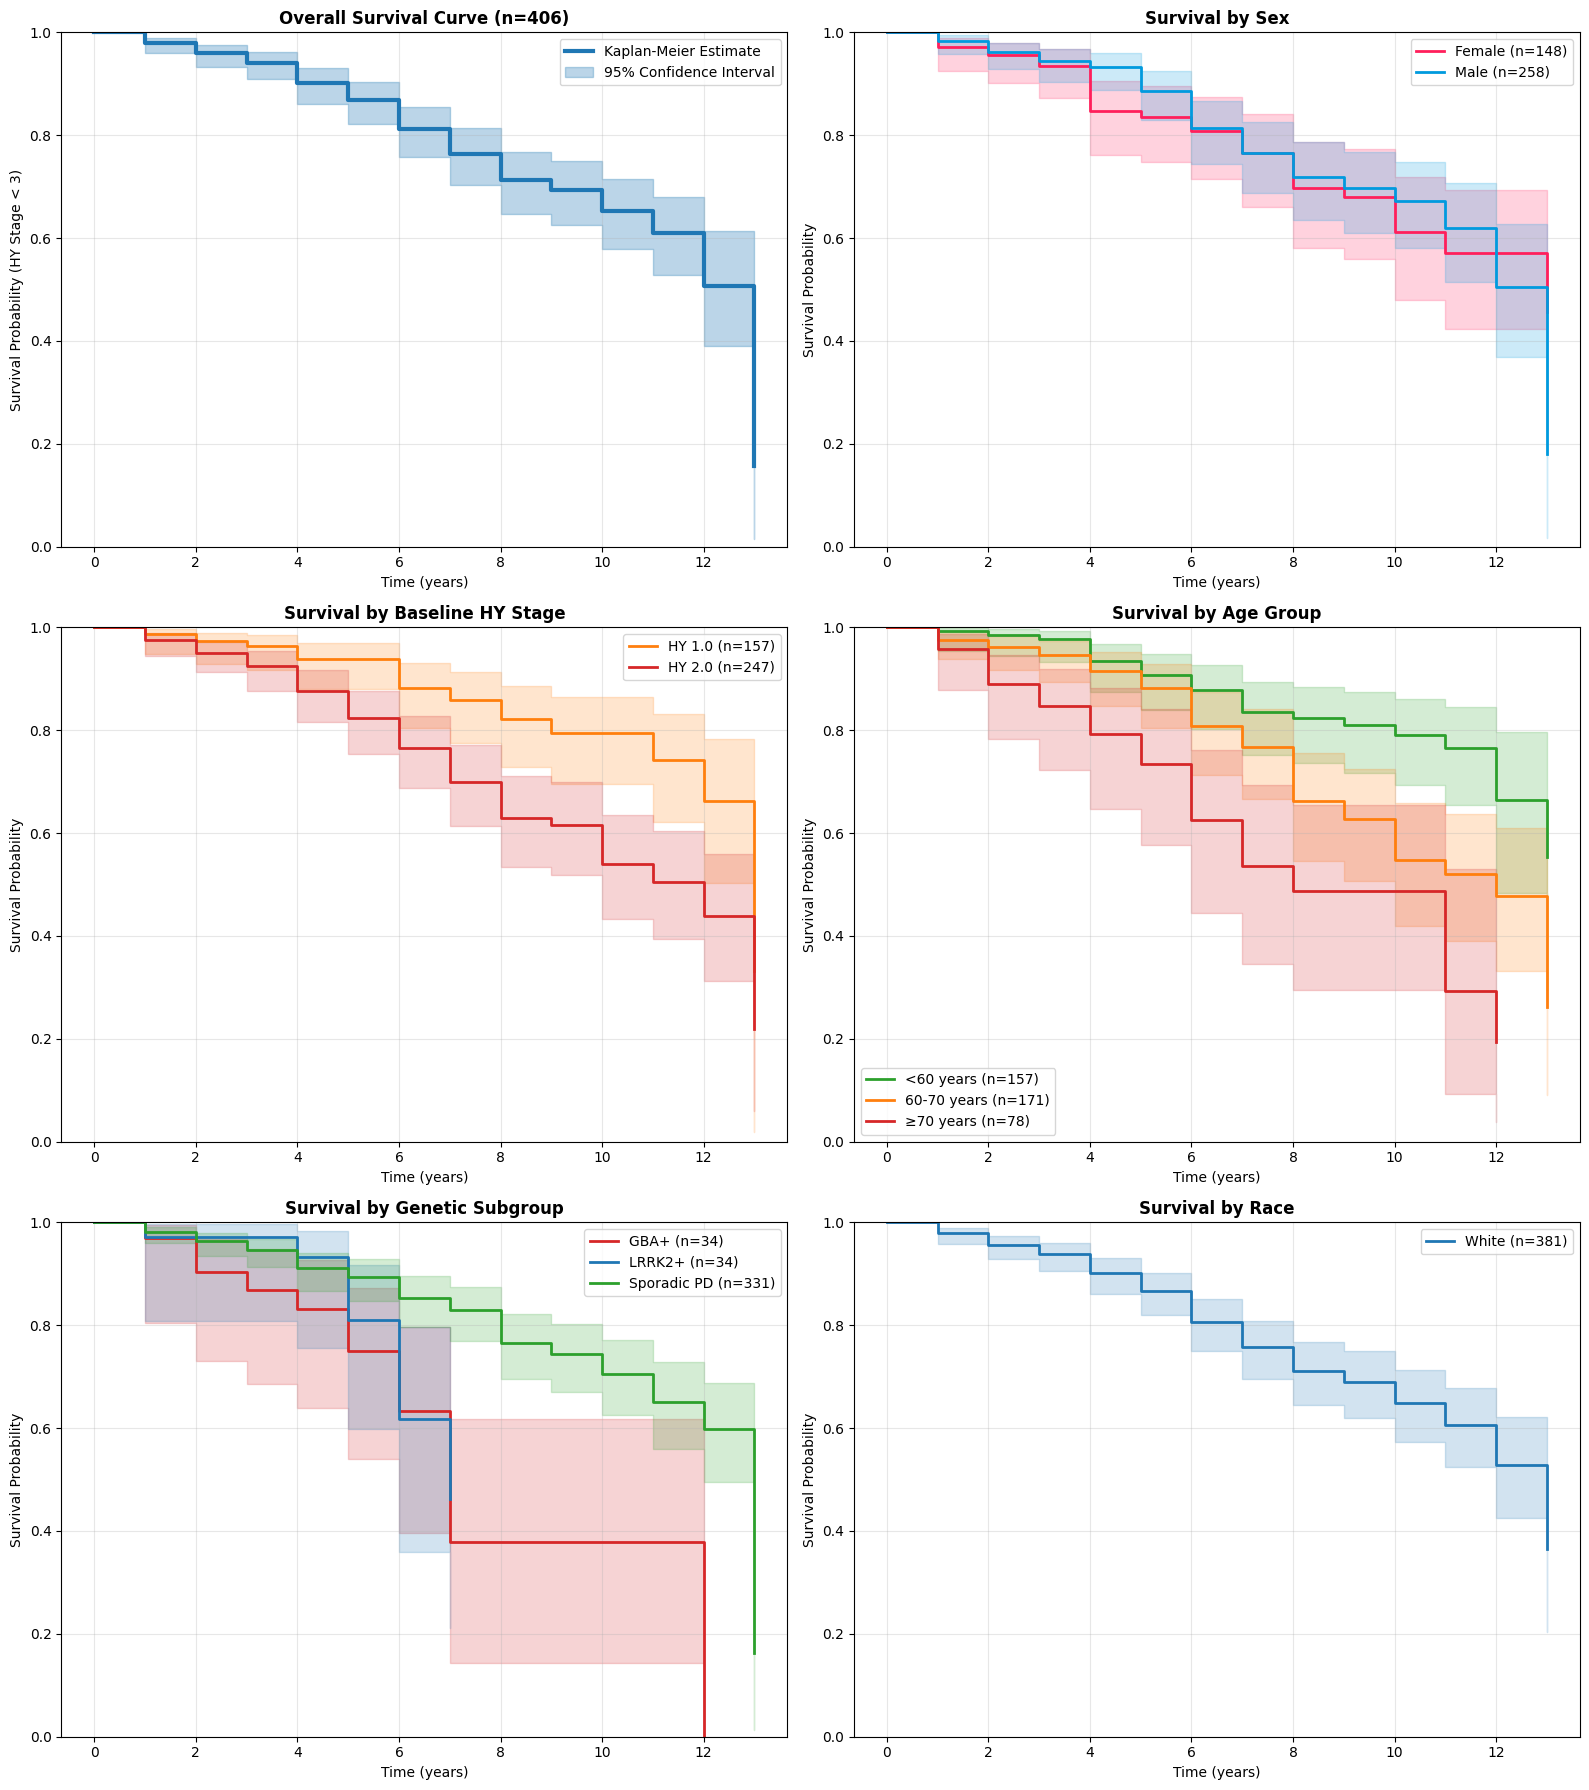


ENHANCED SURVIVAL STATISTICS WITH CONFIDENCE INTERVALS
Median survival time: 13.00 years
95% CI for median survival: [12.00, 13.00] years

Survival probabilities at specific time points:
  At 1 year(s): 0.998 (95% CI: [0.983, 1.000])
  At 2 year(s): 0.977 (95% CI: [0.956, 0.988])
  At 3 year(s): 0.955 (95% CI: [0.928, 0.973])
  At 5 year(s): 0.897 (95% CI: [0.856, 0.927])

STRATIFIED SURVIVAL ANALYSIS WITH CONFIDENCE INTERVALS

STRATIFIED SURVIVAL ANALYSIS
Checking baseline HY distribution:
hy
0.0      2
1.0    157
2.0    247
Name: count, dtype: int64

Group distributions:

Detailed HY grouping:
baseline_hy_group_detailed
HY 2 (Bilateral)     247
HY 1 (Unilateral)    157
HY 0 (No signs)        2
Name: count, dtype: int64

Simple HY grouping:
baseline_hy_group_simple
HY 1-2 (Symptomatic)    404
HY 0 (No signs)           2
Name: count, dtype: int64

Sex grouping:
sex_group
Male      258
Female    148
Name: count, dtype: int64

Age grouping:
age_group
60-70 years (Middle)       171
<60 y

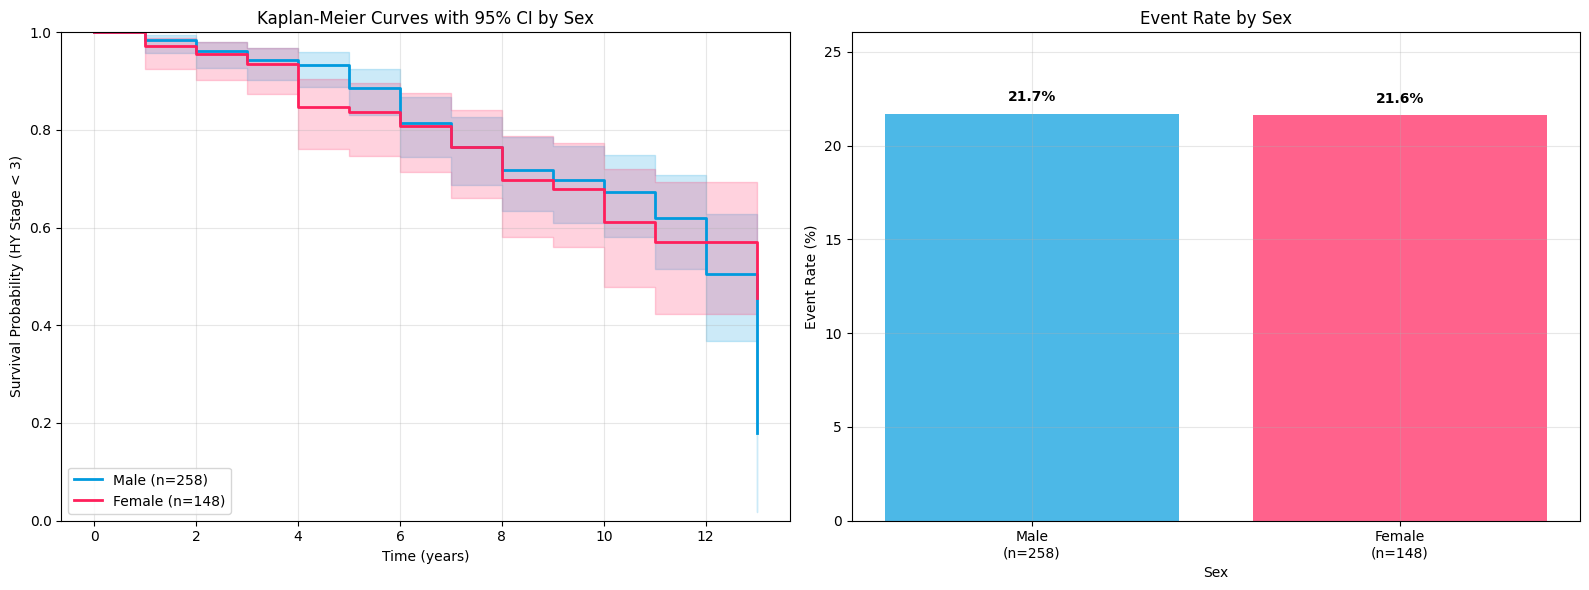

Successfully created KM curves with CI for Sex

ANALYSIS BY BASELINE HY STAGE (SIMPLE) (WITH CONFIDENCE INTERVALS)
Group distribution:
  HY 1-2 (Symptomatic): 404 patients
  HY 0 (No signs): 2 patients
Skipping Baseline HY Stage (Simple) - insufficient data for comparison (need at least 2 groups with ≥15 patients each)

ANALYSIS BY BASELINE HY STAGE (DETAILED) (WITH CONFIDENCE INTERVALS)
Group distribution:
  HY 2 (Bilateral): 247 patients
  HY 1 (Unilateral): 157 patients
  HY 0 (No signs): 2 patients
Group variable: baseline_hy_group_detailed
Available groups: ['HY 2 (Bilateral)', 'HY 1 (Unilateral)', 'HY 0 (No signs)']
Color map: {'HY 0 (No signs)': '#2ca02c', 'HY 1 (Unilateral)': '#ff7f0e', 'HY 2 (Bilateral)': '#d62728', 'HY 3+ (Advanced)': '#9467bd'}
Skipping group 'HY 0 (No signs)' in Baseline HY Stage (Detailed): insufficient sample size (n=2)


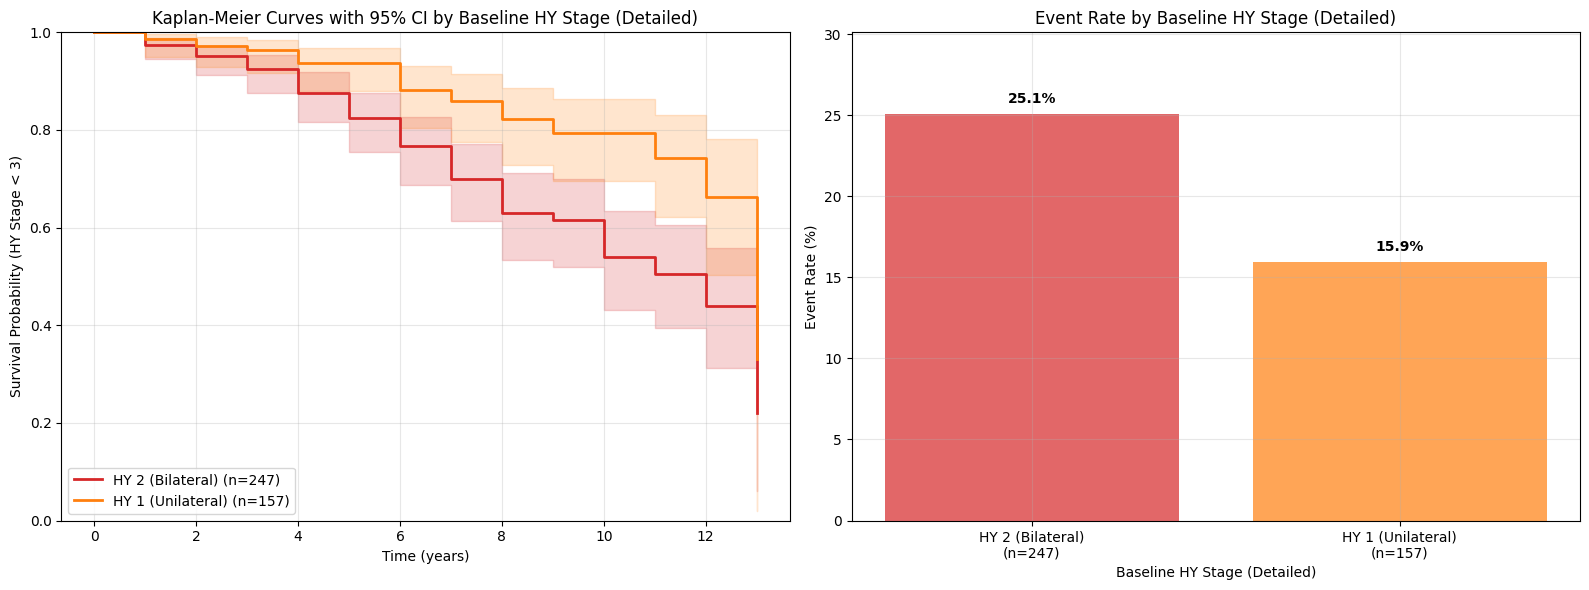

Successfully created KM curves with CI for Baseline HY Stage (Detailed)

ANALYSIS BY AGE GROUP (WITH CONFIDENCE INTERVALS)
Group distribution:
  60-70 years (Middle): 171 patients
  <60 years (Young onset): 157 patients
  ≥70 years (Late onset): 78 patients
Group variable: age_group
Available groups: ['60-70 years (Middle)', '<60 years (Young onset)', '≥70 years (Late onset)']
Color map: {'<60 years (Young onset)': '#2ca02c', '60-70 years (Middle)': '#ff7f0e', '≥70 years (Late onset)': '#d62728'}


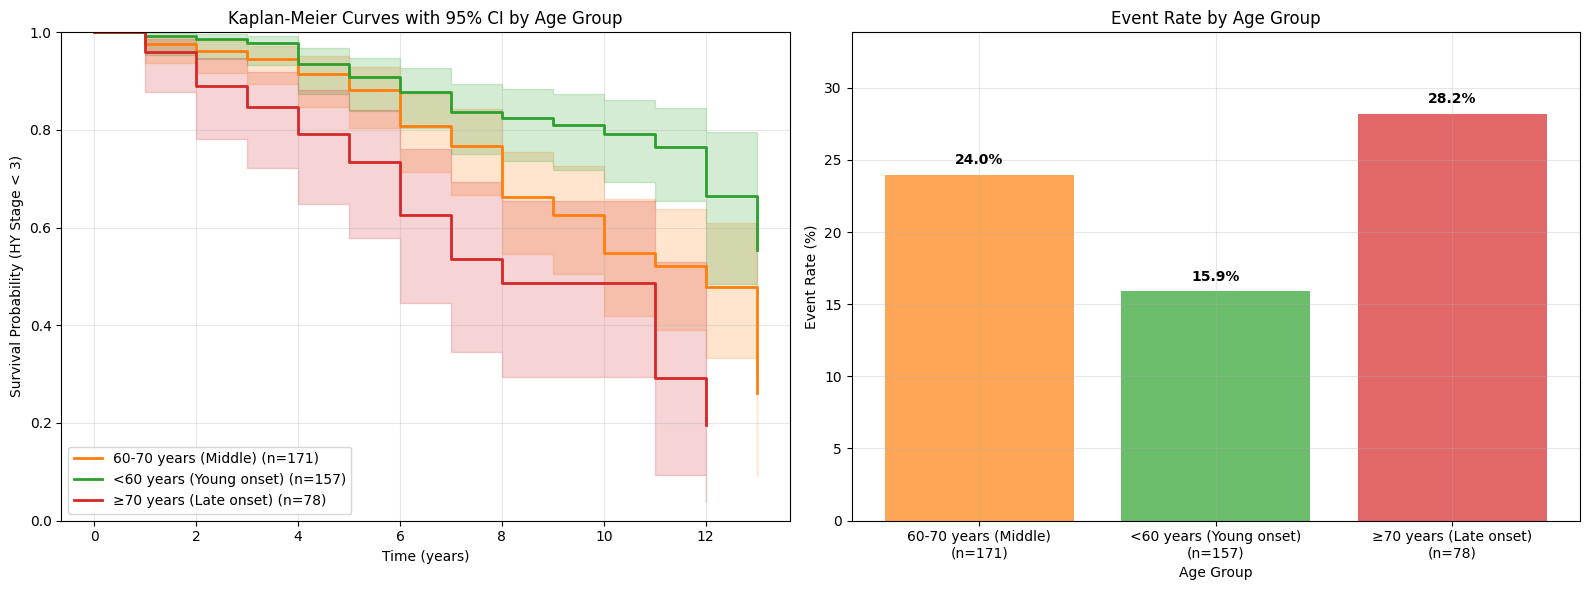

Successfully created KM curves with CI for Age Group

ANALYSIS BY GENETIC SUBGROUP (WITH CONFIDENCE INTERVALS)
Group distribution:
  Sporadic PD: 331 patients
  LRRK2+: 34 patients
  GBA+: 34 patients
  PRKN+: 7 patients
Group variable: genetic_subgroup
Available groups: ['Sporadic PD', 'LRRK2+', 'GBA+', 'PRKN+']
Color map: {'GBA+': '#d62728', 'LRRK2+': '#1f77b4', 'Sporadic PD': '#2ca02c', 'Other/Unknown': '#7f7f7f'}
Skipping group 'PRKN+' in Genetic Subgroup: insufficient sample size (n=7)


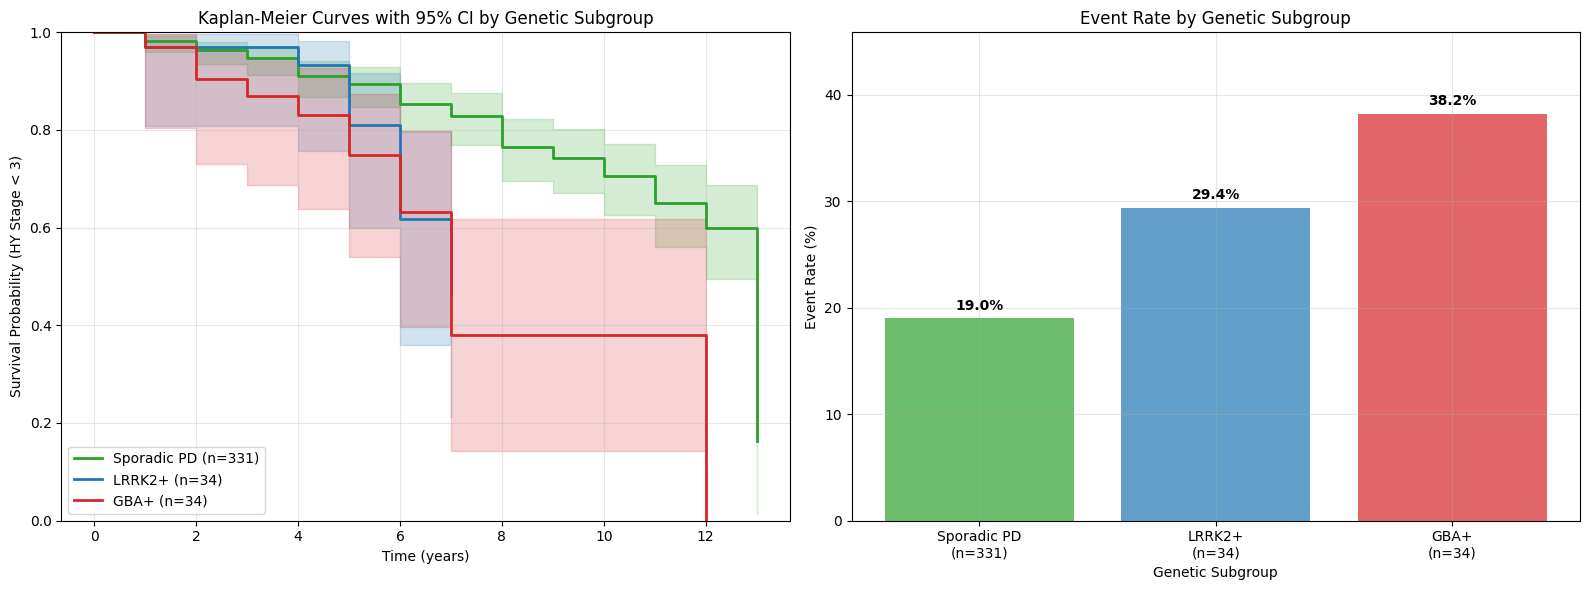

Successfully created KM curves with CI for Genetic Subgroup

ANALYSIS BY RACE (WITH CONFIDENCE INTERVALS)
Group distribution:
  White: 381 patients
  Other: 10 patients
  Asian: 9 patients
  Black: 6 patients
Skipping Race - insufficient data for comparison (need at least 2 groups with ≥15 patients each)


In [6]:
ANALYSIS_COLORS = {
    'overall': '#1f77b4',  # Blue
    'sex': {
        'Female': '#ff1f5b',  # Red
        'Male': '#009ade'     # Blue
    },
    'sex_group': {
        'Female': '#ff1f5b',  # Red
        'Male': '#009ade'     # Blue
    },
    'hy': {
        0: '#2ca02c',    # Green
        1: '#ff7f0e',    # Orange
        2: '#d62728',    # Red
        3: '#9467bd'     # Purple
    },
    'baseline_hy_group_simple': {
        'HY 0 (No signs)': '#2ca02c',         # Green
        'HY 1-2 (Symptomatic)': '#ff7f0e',   # Orange
        'HY 3+ (Advanced)': '#d62728'        # Red
    },
    'baseline_hy_group_detailed': {
        'HY 0 (No signs)': '#2ca02c',      # Green
        'HY 1 (Unilateral)': '#ff7f0e',    # Orange
        'HY 2 (Bilateral)': '#d62728',     # Red
        'HY 3+ (Advanced)': '#9467bd'      # Purple
    },
    'age': {
        '<60 years': '#2ca02c',      # Green
        '60-70 years': '#ff7f0e',    # Orange
        '≥70 years': '#d62728'       # Red
    },
    'age_group': {
        '<60 years (Young onset)': '#2ca02c',    # Green
        '60-70 years (Middle)': '#ff7f0e',       # Orange
        '≥70 years (Late onset)': '#d62728'      # Red
    },
    'genetic': {
        'GBA+': '#d62728',           # Red
        'LRRK2+': '#1f77b4',         # Blue
        'Sporadic PD': '#2ca02c',    # Green
        'Other/Unknown': '#7f7f7f'   # Gray
    },
    'genetic_subgroup': { 
        'GBA+': '#d62728',           # Red
        'LRRK2+': '#1f77b4',         # Blue
        'Sporadic PD': '#2ca02c',    # Green
        'Other/Unknown': '#7f7f7f'   # Gray
    },
    'race': {
        'White': '#1f77b4',          # Blue
        'Black': '#ff7f0e',          # Orange
        'Asian': '#2ca02c',          # Green
        'Other': '#d62728'           # Red
    },
    'race_group': {
        'White': '#1f77b4',          # Blue
        'Black': '#ff7f0e',          # Orange
        'Asian': '#2ca02c',          # Green
        'Other': '#d62728'           # Red
    },
    'duration_group': {
        '≤1 year (Very early)': '#2ca02c',     # Green
        '1-3 years (Early)': '#ff7f0e',        # Orange
        '>3 years (Established)': '#d62728'    # Red
    }
}

def enhanced_survival_statistics_with_ci(modeling_dataset):
    """
    Enhanced survival statistics including median survival times with CI
    """
    print("\n" + "=" * 70)
    print("ENHANCED SURVIVAL STATISTICS WITH CONFIDENCE INTERVALS")
    print("=" * 70)
    
    # Overall statistics
    times, probs, lower_ci, upper_ci = create_kaplan_meier_curve_with_ci(modeling_dataset)
    
    if times and probs:
        # Find median survival time (when survival probability drops to 0.5)
        median_survival_idx = None
        for i, prob in enumerate(probs):
            if prob <= 0.5:
                median_survival_idx = i
                break
        
        if median_survival_idx is not None:
            median_survival = times[median_survival_idx]
            median_ci_lower = None
            median_ci_upper = None
            
            # Find CI for median survival
            for i, ci_lower in enumerate(lower_ci):
                if ci_lower <= 0.5 and median_ci_lower is None:
                    median_ci_lower = times[i]
            
            for i, ci_upper in enumerate(upper_ci):
                if ci_upper <= 0.5 and median_ci_upper is None:
                    median_ci_upper = times[i]
            
            print(f"Median survival time: {median_survival:.2f} years")
            if median_ci_lower is not None and median_ci_upper is not None:
                print(f"95% CI for median survival: [{median_ci_lower:.2f}, {median_ci_upper:.2f}] years")
            else:
                print(f"95% CI for median survival: Could not be estimated")
        else:
            print("Median survival time: Not reached (>50% of patients remain event-free)")
        
        # Survival probabilities at specific time points
        time_points = [1, 2, 3, 5]
        print(f"\nSurvival probabilities at specific time points:")
        for time_point in time_points:
            # Find closest time point
            closest_idx = None
            for i, t in enumerate(times):
                if t >= time_point:
                    closest_idx = i
                    break
            
            if closest_idx is not None:
                prob_at_t = probs[closest_idx]
                ci_lower_at_t = lower_ci[closest_idx]
                ci_upper_at_t = upper_ci[closest_idx]
                print(f"  At {time_point} year(s): {prob_at_t:.3f} (95% CI: [{ci_lower_at_t:.3f}, {ci_upper_at_t:.3f}])")

def create_comprehensive_km_plot_with_ci(modeling_dataset):
    """
    Create comprehensive Kaplan-Meier plot with confidence intervals including genetic subgroups and race
    """
    print("\n" + "=" * 70)
    print("COMPREHENSIVE KAPLAN-MEIER ANALYSIS WITH CONFIDENCE INTERVALS")
    print("=" * 70)
    
    # Create 2x3 subplot layout for 6 plots
    fig, axes = plt.subplots(3, 2, figsize=(16, 18))
    # fig.suptitle('Comprehensive Survival Analysis with Confidence Intervals', fontsize=16, fontweight='bold')
    
    # Flatten axes for easier indexing
    axes = axes.ravel()
    
    # 1. Overall survival curve
    ax1 = axes[0]
    times, probs, lower_ci, upper_ci = create_kaplan_meier_curve_with_ci(modeling_dataset)
    
    if times and probs:
        ax1.step(times, probs, where='post', linewidth=3, color=ANALYSIS_COLORS['overall'], 
                label='Kaplan-Meier Estimate')
        ax1.fill_between(times, lower_ci, upper_ci, step='post', alpha=0.3, 
                        color=ANALYSIS_COLORS['overall'], label='95% Confidence Interval')
        ax1.set_xlabel('Time (years)')
        ax1.set_ylabel('Survival Probability (HY Stage < 3)')
        ax1.set_title(f'Overall Survival Curve (n={len(modeling_dataset)})', fontsize=12, fontweight='bold')
        ax1.set_ylim(0, 1)
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # # Add risk table
        # max_time = max(times) if times else 5
        # risk_times = np.arange(0, min(max_time + 1, 8), 1)
        # n_at_risk_values = []
        # for t in risk_times:
        #     n_at_risk = len(modeling_dataset[modeling_dataset['time_to_hy3_plus'] >= t])
        #     n_at_risk_values.append(n_at_risk)
        
        # # Add risk table as text
        # risk_table_text = "Number at risk:\n" + "".join([f"{t:.0f}" for t in risk_times]) + "\n" + " ".join([f"{n}" for n in n_at_risk_values])
        # ax1.text(0.02, 0.02, risk_table_text, transform=ax1.transAxes, fontsize=8, 
        #         verticalalignment='bottom', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # 2. Survival by Sex with CI
    ax2 = axes[1]
    sex_mapping = {0: 'Female', 1: 'Male'}
    modeling_dataset_sex = modeling_dataset.copy()
    modeling_dataset_sex['sex_label'] = modeling_dataset_sex['sex'].map(sex_mapping)
    
    sex_plotted = False
    
    for sex in ['Female', 'Male']:
        sex_data = modeling_dataset_sex[modeling_dataset_sex['sex_label'] == sex]
        print(f"Sex '{sex}': n={len(sex_data)}")
        
        if len(sex_data) >= 15:
            times_sex, probs_sex, lower_ci_sex, upper_ci_sex = create_kaplan_meier_curve_with_ci(sex_data)
            if times_sex and probs_sex:
                ax2.step(times_sex, probs_sex, where='post', linewidth=2, 
                        color=ANALYSIS_COLORS['sex'][sex], label=f'{sex} (n={len(sex_data)})')
                ax2.fill_between(times_sex, lower_ci_sex, upper_ci_sex, 
                               step='post', alpha=0.2, color=ANALYSIS_COLORS['sex'][sex])
                sex_plotted = True
    
    ax2.set_xlabel('Time (years)')
    ax2.set_ylabel('Survival Probability')
    ax2.set_title('Survival by Sex', fontsize=12, fontweight='bold')
    ax2.set_ylim(0, 1)
    if sex_plotted:
        ax2.legend()
    else:
        ax2.text(0.5, 0.5, 'Insufficient sample size\nfor sex comparison', 
                ha='center', va='center', transform=ax2.transAxes, fontsize=12)
    ax2.grid(True, alpha=0.3)
    
    # 3. Survival by HY Stage with CI
    ax3 = axes[2]
    hy_groups = modeling_dataset['hy'].unique()
    hy_groups = sorted([hy for hy in hy_groups if not pd.isna(hy)])
    hy_plotted = False
    
    for hy in hy_groups:
        hy_data = modeling_dataset[modeling_dataset['hy'] == hy]
        print(f"HY Stage {hy}: n={len(hy_data)}")
        
        if len(hy_data) >= 15:
            times_hy, probs_hy, lower_ci_hy, upper_ci_hy = create_kaplan_meier_curve_with_ci(hy_data)
            if times_hy and probs_hy:
                color = ANALYSIS_COLORS['hy'].get(hy, '#000000') 
                ax3.step(times_hy, probs_hy, where='post', linewidth=2, 
                        color=color, label=f'HY {hy} (n={len(hy_data)})')
                ax3.fill_between(times_hy, lower_ci_hy, upper_ci_hy, 
                               step='post', alpha=0.2, color=color)
                hy_plotted = True
    
    ax3.set_xlabel('Time (years)')
    ax3.set_ylabel('Survival Probability')
    ax3.set_title('Survival by Baseline HY Stage', fontsize=12, fontweight='bold')
    ax3.set_ylim(0, 1)
    if hy_plotted:
        ax3.legend()
    else:
        ax3.text(0.5, 0.5, 'Insufficient sample size\nfor HY stage comparison', 
                ha='center', va='center', transform=ax3.transAxes, fontsize=12)
    ax3.grid(True, alpha=0.3)
    
    # 4. Survival by Age Group with CI
    ax4 = axes[3]
    def categorize_age(age):
        if pd.isna(age):
            return None
        elif age < 60:
            return '<60 years'
        elif age < 70:
            return '60-70 years'
        else:
            return '≥70 years'
    
    modeling_dataset_age = modeling_dataset.copy()
    modeling_dataset_age['age_group'] = modeling_dataset_age['age'].apply(categorize_age)
    
    age_groups = ['<60 years', '60-70 years', '≥70 years']
    age_plotted = False
    
    for age_group in age_groups:
        age_data = modeling_dataset_age[modeling_dataset_age['age_group'] == age_group]
        print(f"Age group '{age_group}': n={len(age_data)}")
        
        if len(age_data) >= 15:
            times_age, probs_age, lower_ci_age, upper_ci_age = create_kaplan_meier_curve_with_ci(age_data)
            if times_age and probs_age:
                ax4.step(times_age, probs_age, where='post', linewidth=2, 
                        color=ANALYSIS_COLORS['age'][age_group], label=f'{age_group} (n={len(age_data)})')
                ax4.fill_between(times_age, lower_ci_age, upper_ci_age, 
                               step='post', alpha=0.2, color=ANALYSIS_COLORS['age'][age_group])
                age_plotted = True
    
    ax4.set_xlabel('Time (years)')
    ax4.set_ylabel('Survival Probability')
    ax4.set_title('Survival by Age Group', fontsize=12, fontweight='bold')
    ax4.set_ylim(0, 1)
    if age_plotted:
        ax4.legend()
    else:
        ax4.text(0.5, 0.5, 'Insufficient sample size\nfor age group comparison', 
                ha='center', va='center', transform=ax4.transAxes, fontsize=12)
    ax4.grid(True, alpha=0.3)
    
    # 5. Survival by Genetic Subgroups with CI
    ax5 = axes[4]
    
    # Create genetic subgroup labels
    def determine_genetic_subgroup(row):
        if pd.notna(row.get('subgroup_gba', 0)) and row.get('subgroup_gba', 0) == True:
            return 'GBA+'
        elif pd.notna(row.get('subgroup_lrrk2', 0)) and row.get('subgroup_lrrk2', 0) == True:
            return 'LRRK2+'
        elif pd.notna(row.get('subgroup_sporadic_pd', 0)) and row.get('subgroup_sporadic_pd', 0) == True:
            return 'Sporadic PD'
        else:
            return 'Other/Unknown'
    
    modeling_dataset_genetic = modeling_dataset.copy()
    modeling_dataset_genetic['genetic_subgroup'] = modeling_dataset_genetic.apply(determine_genetic_subgroup, axis=1)
    
    # Print genetic subgroup distribution
    print("\nGenetic Subgroup Distribution:")
    genetic_counts = modeling_dataset_genetic['genetic_subgroup'].value_counts()
    for subgroup, count in genetic_counts.items():
        print(f"  {subgroup}: {count} patients")
    
    genetic_groups = ['GBA+', 'LRRK2+', 'Sporadic PD', 'Other/Unknown']
    genetic_plotted = False
    
    for genetic_group in genetic_groups:
        genetic_data = modeling_dataset_genetic[modeling_dataset_genetic['genetic_subgroup'] == genetic_group]
        print(f"Genetic subgroup '{genetic_group}': n={len(genetic_data)}")
        
        if len(genetic_data) >= 15:
            times_genetic, probs_genetic, lower_ci_genetic, upper_ci_genetic = create_kaplan_meier_curve_with_ci(genetic_data)
            if times_genetic and probs_genetic:
                ax5.step(times_genetic, probs_genetic, where='post', linewidth=2, 
                        color=ANALYSIS_COLORS['genetic'][genetic_group], label=f'{genetic_group} (n={len(genetic_data)})')
                ax5.fill_between(times_genetic, lower_ci_genetic, upper_ci_genetic, 
                               step='post', alpha=0.2, color=ANALYSIS_COLORS['genetic'][genetic_group])
                genetic_plotted = True
    
    ax5.set_xlabel('Time (years)')
    ax5.set_ylabel('Survival Probability')
    ax5.set_title('Survival by Genetic Subgroup', fontsize=12, fontweight='bold')
    ax5.set_ylim(0, 1)
    if genetic_plotted:
        ax5.legend(loc='upper right')
    else:
        ax5.text(0.5, 0.5, 'Insufficient sample size\nfor genetic subgroup comparison', 
                ha='center', va='center', transform=ax5.transAxes, fontsize=12)
    ax5.grid(True, alpha=0.3)
    
    # 6. NEW: Survival by Race with CI
    ax6 = axes[5]
    
    # Create race labels from one-hot encoded columns
    def determine_race_group(row):
        if row.get('race_white', 0) == True:
            return 'White'
        elif row.get('race_black', 0) == True:
            return 'Black'
        elif row.get('race_asian', 0) == True:
            return 'Asian'
        elif row.get('race_other', 0) == True:
            return 'Other'
        else:
            return 'Unknown'
    
    modeling_dataset_race = modeling_dataset.copy()
    modeling_dataset_race['race_group'] = modeling_dataset_race.apply(determine_race_group, axis=1)
    
    # Print race group distribution
    print("\nRace Group Distribution:")
    race_counts = modeling_dataset_race['race_group'].value_counts()
    for race_group, count in race_counts.items():
        print(f"  {race_group}: {count} patients")
    
    race_groups = ['White', 'Black', 'Asian', 'Other']
    race_plotted = False
    
    for race_group in race_groups:
        race_data = modeling_dataset_race[modeling_dataset_race['race_group'] == race_group]
        print(f"Race group '{race_group}': n={len(race_data)}")
        
        if len(race_data) >= 15: 
            times_race, probs_race, lower_ci_race, upper_ci_race = create_kaplan_meier_curve_with_ci(race_data)
            if times_race and probs_race:
                ax6.step(times_race, probs_race, where='post', linewidth=2, 
                        color=ANALYSIS_COLORS['race'][race_group], label=f'{race_group} (n={len(race_data)})')
                ax6.fill_between(times_race, lower_ci_race, upper_ci_race, 
                               step='post', alpha=0.2, color=ANALYSIS_COLORS['race'][race_group])
                race_plotted = True
    
    ax6.set_xlabel('Time (years)')
    ax6.set_ylabel('Survival Probability')
    ax6.set_title('Survival by Race', fontsize=12, fontweight='bold')
    ax6.set_ylim(0, 1)
    if race_plotted:
        ax6.legend()
    else:
        ax6.text(0.5, 0.5, 'Insufficient sample size\nfor race comparison', 
                ha='center', va='center', transform=ax6.transAxes, fontsize=12)
    ax6.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def create_stratified_survival_analysis(modeling_dataset):
    """
    Create stratified survival analysis by different patient groups
    """
    print("\n" + "=" * 70)
    print("STRATIFIED SURVIVAL ANALYSIS")
    print("=" * 70)
    
    # First, let's check the actual distribution of baseline HY values
    print("Checking baseline HY distribution:")
    hy_distribution = modeling_dataset['hy'].value_counts().sort_index()
    print(hy_distribution)
    print()
    
    # Create derived grouping variables
    dataset_with_groups = modeling_dataset.copy()
    
    # 1. Baseline HY groups - based on actual integer values (0, 1, 2, etc.)
    def categorize_baseline_hy_detailed(hy):
        if pd.isna(hy):
            return 'Missing'
        elif hy == 0:
            return 'HY 0 (No signs)'
        elif hy == 1:
            return 'HY 1 (Unilateral)'
        elif hy == 2:
            return 'HY 2 (Bilateral)'
        else:  # hy >= 3 (this shouldn't exist in our dataset since we excluded HY3+ at baseline)
            return 'HY 3+ (Advanced)'
    
    dataset_with_groups['baseline_hy_group_detailed'] = dataset_with_groups['hy'].apply(categorize_baseline_hy_detailed)
    
    # 2. Simplified HY grouping for better statistical power
    def categorize_baseline_hy_simple(hy):
        if pd.isna(hy):
            return 'Missing'
        elif hy == 0:
            return 'HY 0 (No signs)'
        elif hy in [1, 2]:
            return 'HY 1-2 (Symptomatic)'
        else:
            return 'HY 3+ (Advanced)'  # Shouldn't exist but just in case
    
    dataset_with_groups['baseline_hy_group_simple'] = dataset_with_groups['hy'].apply(categorize_baseline_hy_simple)
    
    # 3. Age groups (at enrollment)
    def categorize_age(age):
        if pd.isna(age):
            return 'Missing'
        elif age < 60:
            return '<60 years (Young onset)'
        elif age < 70:
            return '60-70 years (Middle)'
        else:
            return '≥70 years (Late onset)'
    
    dataset_with_groups['age_group'] = dataset_with_groups['age'].apply(categorize_age)
    
    # 4. Genetic subgroups
    def determine_genetic_subgroup(row):
        if pd.notna(row.get('subgroup_gba', 0)) and row.get('subgroup_gba', 0) == True:
            return 'GBA+'
        elif pd.notna(row.get('subgroup_lrrk2', 0)) and row.get('subgroup_lrrk2', 0) == True:
            return 'LRRK2+'
        elif pd.notna(row.get('subgroup_sporadic_pd', 0)) and row.get('subgroup_sporadic_pd', 0) == True:
            return 'Sporadic PD'
        elif pd.notna(row.get('subgroup_prkn', 0)) and row.get('subgroup_prkn', 0) == True:
            return 'PRKN+'
        elif pd.notna(row.get('subgroup_normosmic', 0)) and row.get('subgroup_normosmic', 0) == True:
            return 'Normosmic PD'
        elif pd.notna(row.get('subgroup_snca', 0)) and row.get('subgroup_snca', 0) == True:
            return 'SNCA+'
        else:
            print(row)
            return 'Other/Unknown'
    
    dataset_with_groups['genetic_subgroup'] = dataset_with_groups.apply(determine_genetic_subgroup, axis=1)
    
    # 5. Disease duration groups
    def categorize_duration(duration):
        if pd.isna(duration):
            return 'Missing'
        elif duration <= 1:
            return '≤1 year (Very early)'
        elif duration <= 3:
            return '1-3 years (Early)'
        else:
            return '>3 years (Established)'
    
    dataset_with_groups['duration_group'] = dataset_with_groups['duration_yrs'].apply(categorize_duration)
    
    # 6. Sex grouping (simple)
    def categorize_sex(sex):
        if pd.isna(sex):
            return 'Missing'
        elif sex == 0:
            return 'Female'
        elif sex == 1:
            return 'Male'
        else:
            return 'Other'
    
    dataset_with_groups['sex_group'] = dataset_with_groups['sex'].apply(categorize_sex)
    
    # Print group distributions to help decide which grouping to use
    print("Group distributions:")
    print("\nDetailed HY grouping:")
    print(dataset_with_groups['baseline_hy_group_detailed'].value_counts())
    print("\nSimple HY grouping:")
    print(dataset_with_groups['baseline_hy_group_simple'].value_counts())
    print("\nSex grouping:")
    print(dataset_with_groups['sex_group'].value_counts())
    print("\nAge grouping:")
    print(dataset_with_groups['age_group'].value_counts())
    print("\nGenetic grouping:")
    print(dataset_with_groups['genetic_subgroup'].value_counts())
    print("\nDuration grouping:")
    print(dataset_with_groups['duration_group'].value_counts())
    
    return dataset_with_groups

def create_stratified_survival_analysis_with_ci(modeling_dataset):
    """
    Create stratified survival analysis with confidence intervals
    """
    print("\n" + "=" * 70)
    print("STRATIFIED SURVIVAL ANALYSIS WITH CONFIDENCE INTERVALS")
    print("=" * 70)
    
    # Create dataset with grouping variables
    dataset_with_groups = create_stratified_survival_analysis(modeling_dataset)

    # Determine race group
    def determine_race_group(row):
        if row.get('race_white', 0) == True:
            return 'White'
        elif row.get('race_black', 0) == True:
            return 'Black'
        elif row.get('race_asian', 0) == True:
            return 'Asian'
        elif row.get('race_other', 0) == True:
            return 'Other'
        else:
            return 'Unknown'
    
    dataset_with_groups['race_group'] = dataset_with_groups.apply(determine_race_group, axis=1)
    
    # Define the stratification variables to analyze (添加race_group)
    stratification_analyses = [
        ('sex_group', 'Sex'),
        ('baseline_hy_group_simple', 'Baseline HY Stage (Simple)'),
        ('baseline_hy_group_detailed', 'Baseline HY Stage (Detailed)'),
        ('age_group', 'Age Group'),
        ('genetic_subgroup', 'Genetic Subgroup'),
        ('race_group', 'Race'), 
    ]
    
    # Perform analysis for each stratification with CI
    for group_var, group_name in stratification_analyses:
        print(f"\n{'='*60}")
        print(f"ANALYSIS BY {group_name.upper()} (WITH CONFIDENCE INTERVALS)")
        print(f"{'='*60}")
        
        # Check if we have enough data
        group_counts = dataset_with_groups[group_var].value_counts()
        print(f"Group distribution:")
        for group, count in group_counts.items():
            print(f"  {group}: {count} patients")
        
        valid_groups = [g for g, c in group_counts.items() if c >= 15 and g not in ['Missing', 'Unknown']]
        
        if len(valid_groups) >= 2:
            try:
                survival_data = plot_kaplan_meier_by_groups_with_ci(dataset_with_groups, group_var, group_name)
                print(f"Successfully created KM curves with CI for {group_name}")
            except Exception as e:
                print(f"Error in analysis for {group_name}: {str(e)}")
        else:
            print(f"Skipping {group_name} - insufficient data for comparison (need at least 2 groups with ≥15 patients each)")

def create_kaplan_meier_curve_with_ci(analysable_data, confidence_level=0.95):
    """
    Create a proper Kaplan-Meier survival curve with confidence intervals
    """
    if len(analysable_data) == 0:
        return None, None, None, None
    
    # Sort by time
    sorted_data = analysable_data.sort_values('time_to_hy3_plus').reset_index(drop=True)
    
    times = [0]  # Start at time 0
    survival_probs = [1.0]  # Start with 100% survival
    lower_ci = [1.0]  # Lower confidence interval
    upper_ci = [1.0]  # Upper confidence interval
    
    n_at_risk = len(sorted_data)
    cumulative_hazard = 0  # For Greenwood's formula
    
    # Calculate z-score for confidence level
    alpha = 1 - confidence_level
    z_score = 1.96 if confidence_level == 0.95 else 2.576 if confidence_level == 0.99 else 1.645
    
    for i, row in sorted_data.iterrows():
        time = row['time_to_hy3_plus']
        event = row['event_occurred']
        
        if event == 1:  # Event occurred
            # Calculate new survival probability using Kaplan-Meier formula
            survival_prob = survival_probs[-1] * (1 - 1/n_at_risk) if n_at_risk > 0 else 0
            
            # Update cumulative hazard for Greenwood's formula (avoid division by zero)
            if n_at_risk > 1:  # Need at least 2 samples for variance calculation
                cumulative_hazard += 1 / (n_at_risk * (n_at_risk - 1))
            
            # Calculate confidence interval using Greenwood's formula
            if survival_prob > 0 and n_at_risk > 1:  # Need sufficient samples for CI
                # Greenwood's variance estimate
                greenwood_var = survival_prob**2 * cumulative_hazard
                
                if greenwood_var > 0:
                    se_log_survival = np.sqrt(greenwood_var) / survival_prob
                    
                    # Check if log transformation is valid
                    if survival_prob < 1.0:  # Avoid log(0)
                        # Log-log transformation for better CI
                        log_log_survival = np.log(-np.log(survival_prob))
                        se_log_log = se_log_survival / (-np.log(survival_prob))
                        
                        # Calculate CI on log-log scale then transform back
                        log_log_lower = log_log_survival - z_score * se_log_log
                        log_log_upper = log_log_survival + z_score * se_log_log
                        
                        ci_lower = np.exp(-np.exp(log_log_upper))
                        ci_upper = np.exp(-np.exp(log_log_lower))
                        
                        # Bound CI to [0, 1]
                        ci_lower = max(0, min(1, ci_lower))
                        ci_upper = max(0, min(1, ci_upper))
                    else:
                        # If survival_prob = 1, use simple normal approximation
                        margin_of_error = z_score * se_log_survival
                        ci_lower = max(0, survival_prob - margin_of_error)
                        ci_upper = min(1, survival_prob + margin_of_error)
                else:
                    # If variance is 0, CI equals the point estimate
                    ci_lower = survival_prob
                    ci_upper = survival_prob
            else:
                # For small samples or edge cases, CI equals the point estimate
                ci_lower = survival_prob
                ci_upper = survival_prob
            
            times.append(time)
            survival_probs.append(survival_prob)
            lower_ci.append(ci_lower)
            upper_ci.append(ci_upper)
        
        n_at_risk -= 1
    
    return times, survival_probs, lower_ci, upper_ci

def plot_kaplan_meier_by_groups_with_ci(dataset_with_groups, group_var, group_name):
    """
    Create Kaplan-Meier survival curves with confidence intervals stratified by a specific grouping variable
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Get unique groups
    groups = dataset_with_groups[group_var].unique()
    groups = [g for g in groups if g not in ['Missing', 'Unknown']]  # Exclude missing/unknown data
    
    # Use consistent colors based on group_var
    color_map = None
    
    if group_var in ANALYSIS_COLORS:
        color_map = ANALYSIS_COLORS[group_var]
    elif group_var == 'sex_group':
        color_map = ANALYSIS_COLORS['sex_group']
    elif 'baseline_hy' in group_var:
        if 'simple' in group_var:
            color_map = ANALYSIS_COLORS['baseline_hy_group_simple']
        else:
            color_map = ANALYSIS_COLORS['baseline_hy_group_detailed']
    elif group_var == 'age_group': 
        color_map = ANALYSIS_COLORS['age_group']
    elif 'age' in group_var and group_var != 'age_group':  
        color_map = ANALYSIS_COLORS['age']
    elif group_var == 'genetic_subgroup':
        color_map = ANALYSIS_COLORS['genetic_subgroup']
    elif group_var == 'race_group':
        color_map = ANALYSIS_COLORS['race_group']
    elif group_var == 'duration_group':
        color_map = ANALYSIS_COLORS['duration_group']

    # Use consistent colors based on group_var
    if color_map is None:
        print(f"Warning: No color mapping found for {group_var}, using default colors")
        colors = plt.cm.Set1(np.linspace(0, 1, len(groups)))
        color_map = {group: colors[i] for i, group in enumerate(groups)}

    # Print debug information
    print(f"Group variable: {group_var}")
    print(f"Available groups: {groups}")
    print(f"Color map: {color_map}")
    
    # Plot 1: Kaplan-Meier curves with CI
    survival_data = {}
    
    for group in groups:
        group_data = dataset_with_groups[dataset_with_groups[group_var] == group]

        if len(group_data) < 10:  # Increase minimum sample size requirement to ensure CI stability
            print(f"Skipping group '{group}' in {group_name}: insufficient sample size (n={len(group_data)})")
            continue
            
        # Calculate Kaplan-Meier curve with CI
        times, probs, lower_ci, upper_ci = create_kaplan_meier_curve_with_ci(group_data)
        
        if times and probs:
            # Get color for this group
            color = color_map.get(group, '#000000')  # Default to black if not found
            if color == '#000000':
                print(f"Warning: Using default black color for group '{group}' in {group_name}")
            
            # Plot survival curve
            ax1.step(times, probs, where='post', linewidth=2, 
                    color=color, label=f'{group} (n={len(group_data)})')
            
            # Plot confidence interval as shaded area
            ax1.fill_between(times, lower_ci, upper_ci, 
                           step='post', alpha=0.2, color=color)
            
            survival_data[group] = {
                'times': times, 
                'probs': probs, 
                'lower_ci': lower_ci,
                'upper_ci': upper_ci,
                'n': len(group_data)
            }
    
    ax1.set_xlabel('Time (years)')
    ax1.set_ylabel('Survival Probability (HY Stage < 3)')
    ax1.set_title(f'Kaplan-Meier Curves with 95% CI by {group_name}')
    ax1.set_ylim(0, 1)
    ax1.legend(loc='lower left')
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Event rates by group
    event_rates = []
    group_labels = []
    bar_colors = []
    
    for group in groups:
        group_data = dataset_with_groups[dataset_with_groups[group_var] == group]
        if len(group_data) >= 10:  # Keep consistent minimum sample size requirement
            event_rate = (group_data['event_occurred'].sum() / len(group_data)) * 100
            event_rates.append(event_rate)
            group_labels.append(f'{group}\n(n={len(group_data)})')
            bar_colors.append(color_map.get(group, '#000000'))

    if event_rates:  # Only plot if there are valid groups
        bars = ax2.bar(range(len(event_rates)), event_rates, color=bar_colors, alpha=0.7)
        ax2.set_xlabel(group_name)
        ax2.set_ylabel('Event Rate (%)')
        ax2.set_title(f'Event Rate by {group_name}')
        ax2.set_xticks(range(len(group_labels)))
        ax2.set_xticklabels(group_labels, rotation=0)
        y_max = max(event_rates) if event_rates else 100
        ax2.set_ylim(0, y_max * 1.2)
        ax2.grid(True, alpha=0.3)
        
        # Add event rate labels on bars
        for i, (bar, rate) in enumerate(zip(bars, event_rates)):
            ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                    f'{rate:.1f}%', ha='center', va='bottom', fontweight='bold')
    else:
        ax2.text(0.5, 0.5, 'No groups with\nsufficient sample size', 
                ha='center', va='center', transform=ax2.transAxes, fontsize=14)
        ax2.set_title(f'Event Rate by {group_name}')
    
    plt.tight_layout()
    plt.show()
    
    return survival_data

modeling_dataset = merged_df.dropna()
# Perform enhanced survival analysis with confidence intervals
if 'modeling_dataset' in locals() and len(modeling_dataset) > 0:
    print("PERFORMING ENHANCED SURVIVAL ANALYSIS WITH CONFIDENCE INTERVALS...")
    print(f"Total modeling dataset size: {len(modeling_dataset)}")
    print(f"Events: {modeling_dataset['event_occurred'].sum()}")
    print(f"Event rate: {(modeling_dataset['event_occurred'].sum() / len(modeling_dataset) * 100):.1f}%")

    # 1. Generate comprehensive KM plot with confidence intervals
    create_comprehensive_km_plot_with_ci(modeling_dataset)

    # 2. Enhanced survival statistics with confidence intervals
    enhanced_survival_statistics_with_ci(modeling_dataset)

    # 3. Create stratified survival analysis with confidence intervals (including genetic subgroups and race)
    create_stratified_survival_analysis_with_ci(modeling_dataset)

else:
    print("No modeling dataset available for enhanced survival analysis")

BASELINE VARIABLE CORRELATION ANALYSIS
1. AGE vs BASELINE HY STAGE ANALYSIS

Age Group vs Baseline HY Stage Cross-tabulation:
hy         0.0  1.0  2.0  All
age_group                    
60-70        0   60  111  171
<60          2   82   73  157
≥70          0   15   63   78
All          2  157  247  406

Percentages within Age Groups:
hy         0.0   1.0   2.0
age_group                 
60-70      0.0  35.1  64.9
<60        1.3  52.2  46.5
≥70        0.0  19.2  80.8

Chi-square test for Age vs HY Stage:
  Chi-square statistic: 29.6935
  p-value: 0.0000
  Degrees of freedom: 4
  Result: Significant association ***

2. AGE vs OTHER KEY VARIABLES

Age Group vs Sex:
sex_label  Female  Male  All
age_group                   
60-70          50   121  171
<60            66    91  157
≥70            32    46   78
All           148   258  406

Percentages within Age Groups:
sex_label  Female  Male
age_group              
60-70        29.2  70.8
<60          42.0  58.0
≥70          41.0  59.0



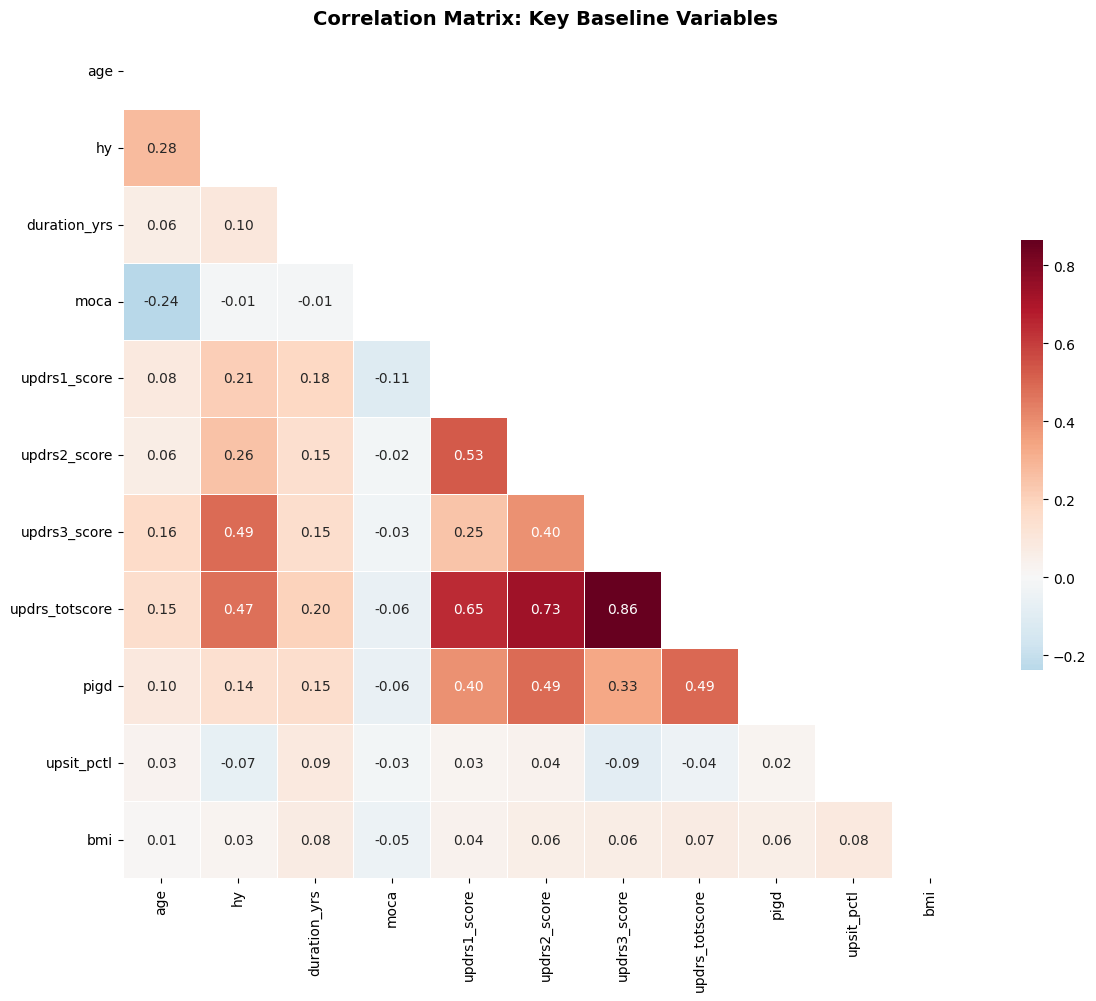


COMBINED RISK FACTOR ANALYSIS
Risk Profile Distribution:
risk_profile
Medium Risk                 199
Low Risk (Age<70, HY≤1)     144
High Risk (Age≥70, HY≥2)     63
Name: count, dtype: int64

Percentages:
risk_profile
Medium Risk                 49.0
Low Risk (Age<70, HY≤1)     35.5
High Risk (Age≥70, HY≥2)    15.5
Name: count, dtype: float64

Event Rates by Risk Profile:
  Medium Risk: 26.1% (52.0/199 patients)
  High Risk (Age≥70, HY≥2): 25.4% (16.0/63 patients)
  Low Risk (Age<70, HY≤1): 13.9% (20.0/144 patients)


In [7]:
def analyze_variable_correlations(dataset):
    """
    Analyze correlations between key baseline variables
    """
    print("=" * 80)
    print("BASELINE VARIABLE CORRELATION ANALYSIS")
    print("=" * 80)
    
    # Prepare the dataset
    analysis_data = dataset.copy()
    
    # Create categorical variables for analysis
    analysis_data['age_group'] = analysis_data['age'].apply(
        lambda x: '<60' if pd.isna(x) else ('<60' if x < 60 else ('60-70' if x < 70 else '≥70'))
    )
    
    analysis_data['sex_label'] = analysis_data['sex'].map({0: 'Female', 1: 'Male'})
    
    # Genetic subgroups
    def determine_genetic_subgroup(row):
        if pd.notna(row.get('subgroup_gba', 0)) and row.get('subgroup_gba', 0) == True:
            return 'GBA+'
        elif pd.notna(row.get('subgroup_lrrk2', 0)) and row.get('subgroup_lrrk2', 0) == True:
            return 'LRRK2+'
        elif pd.notna(row.get('subgroup_sporadic_pd', 0)) and row.get('subgroup_sporadic_pd', 0) == True:
            return 'Sporadic PD'
        else:
            return 'Other/Unknown'
    
    analysis_data['genetic_subgroup'] = analysis_data.apply(determine_genetic_subgroup, axis=1)
    
    # Disease duration groups
    analysis_data['duration_group'] = analysis_data['duration_yrs'].apply(
        lambda x: 'Missing' if pd.isna(x) else ('≤1 year' if x <= 1 else ('1-3 years' if x <= 3 else '>3 years'))
    )
    
    print("1. AGE vs BASELINE HY STAGE ANALYSIS")
    print("=" * 60)
    
    # Age vs HY stage cross-tabulation
    age_hy_crosstab = pd.crosstab(analysis_data['age_group'], analysis_data['hy'], margins=True)
    print("\nAge Group vs Baseline HY Stage Cross-tabulation:")
    print(age_hy_crosstab)
    
    # Calculate percentages within age groups
    age_hy_pct = pd.crosstab(analysis_data['age_group'], analysis_data['hy'], normalize='index') * 100
    print("\nPercentages within Age Groups:")
    print(age_hy_pct.round(1))
    
    # Statistical test: Chi-square test
    from scipy.stats import chi2_contingency
    age_hy_clean = pd.crosstab(analysis_data['age_group'], analysis_data['hy'])
    chi2, p_value, dof, expected = chi2_contingency(age_hy_clean)
    print(f"\nChi-square test for Age vs HY Stage:")
    print(f"  Chi-square statistic: {chi2:.4f}")
    print(f"  p-value: {p_value:.4f}")
    print(f"  Degrees of freedom: {dof}")
    
    significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
    print(f"  Result: {'Significant' if p_value < 0.05 else 'Not significant'} association {significance}")
    
    print("\n2. AGE vs OTHER KEY VARIABLES")
    print("=" * 60)
    
    # Age vs Sex
    print("\nAge Group vs Sex:")
    age_sex_crosstab = pd.crosstab(analysis_data['age_group'], analysis_data['sex_label'], margins=True)
    print(age_sex_crosstab)
    
    age_sex_pct = pd.crosstab(analysis_data['age_group'], analysis_data['sex_label'], normalize='index') * 100
    print("\nPercentages within Age Groups:")
    print(age_sex_pct.round(1))
    
    # Age vs Genetic subgroups
    print("\nAge Group vs Genetic Subgroups:")
    age_genetic_crosstab = pd.crosstab(analysis_data['age_group'], analysis_data['genetic_subgroup'], margins=True)
    print(age_genetic_crosstab)
    
    age_genetic_pct = pd.crosstab(analysis_data['age_group'], analysis_data['genetic_subgroup'], normalize='index') * 100
    print("\nPercentages within Age Groups:")
    print(age_genetic_pct.round(1))
    
    # Age vs Disease duration
    print("\nAge Group vs Disease Duration:")
    age_duration_crosstab = pd.crosstab(analysis_data['age_group'], analysis_data['duration_group'], margins=True)
    print(age_duration_crosstab)
    
    print("\n3. CONTINUOUS VARIABLE CORRELATIONS")
    print("=" * 60)
    
    # Select key continuous variables
    continuous_vars = ['age', 'hy', 'duration_yrs', 'moca', 'updrs1_score', 'updrs2_score', 
                      'updrs3_score', 'updrs_totscore', 'pigd', 'upsit_pctl', 'bmi']
    
    available_vars = [var for var in continuous_vars if var in analysis_data.columns]
    
    # Correlation matrix
    corr_matrix = analysis_data[available_vars].corr()
    
    print("Correlation Matrix (Key Variables):")
    print(corr_matrix.round(3))
    
    # Highlight strong correlations with age
    print(f"\nCorrelations with AGE:")
    age_correlations = corr_matrix['age'].abs().sort_values(ascending=False)
    for var, corr in age_correlations.items():
        if var != 'age':
            direction = "positive" if corr_matrix['age'][var] > 0 else "negative"
            strength = "strong" if abs(corr) > 0.5 else "moderate" if abs(corr) > 0.3 else "weak"
            print(f"  {var:<20}: r = {corr_matrix['age'][var]:>7.3f} ({strength} {direction})")
    
    # Highlight strong correlations with HY stage
    print(f"\nCorrelations with BASELINE HY STAGE:")
    hy_correlations = corr_matrix['hy'].abs().sort_values(ascending=False)
    for var, corr in hy_correlations.items():
        if var != 'hy':
            direction = "positive" if corr_matrix['hy'][var] > 0 else "negative"
            strength = "strong" if abs(corr) > 0.5 else "moderate" if abs(corr) > 0.3 else "weak"
            print(f"  {var:<20}: r = {corr_matrix['hy'][var]:>7.3f} ({strength} {direction})")
    
    print("\n4. CLINICAL SEVERITY ANALYSIS BY AGE")
    print("=" * 60)
    
    # Group by age and show mean clinical scores
    clinical_vars = ['moca', 'updrs1_score', 'updrs2_score', 'updrs3_score', 'updrs_totscore', 'pigd', 'upsit_pctl']
    available_clinical = [var for var in clinical_vars if var in analysis_data.columns]
    
    print("Mean Clinical Scores by Age Group:")
    print("-" * 50)
    
    for var in available_clinical:
        print(f"\n{var.upper()}:")
        age_means = analysis_data.groupby('age_group')[var].agg(['count', 'mean', 'std']).round(2)
        print(age_means)
        
        # ANOVA test
        from scipy.stats import f_oneway
        groups = [group[var].dropna() for name, group in analysis_data.groupby('age_group')]
        if len(groups) >= 2 and all(len(g) > 0 for g in groups):
            f_stat, p_val = f_oneway(*groups)
            significance = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else "ns"
            print(f"ANOVA: F = {f_stat:.4f}, p = {p_val:.4f} {significance}")
    
    print("\n5. HY STAGE ANALYSIS BY OTHER VARIABLES")
    print("=" * 60)
    
    print("Mean Clinical Scores by Baseline HY Stage:")
    print("-" * 50)
    
    for var in available_clinical:
        if var != 'hy':
            print(f"\n{var.upper()}:")
            hy_means = analysis_data.groupby('hy')[var].agg(['count', 'mean', 'std']).round(2)
            print(hy_means)
    
    return analysis_data, corr_matrix

# 运行相关性分析
correlation_data, correlation_matrix = analyze_variable_correlations(modeling_dataset)

# Additional visualization
def create_correlation_heatmap(corr_matrix):
    """
    Create a correlation heatmap
    """
    plt.figure(figsize=(12, 10))
    
    # Create mask for upper triangle
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    
    # Create heatmap
    sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='RdBu_r', center=0,
                square=True, linewidths=0.5, cbar_kws={"shrink": 0.5}, fmt='.2f')
    
    plt.title('Correlation Matrix: Key Baseline Variables', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Create the heatmap
if 'correlation_matrix' in locals():
    create_correlation_heatmap(correlation_matrix)

def analyze_survival_by_combined_factors(dataset):
    """
    Analyze survival patterns by combined risk factors
    """
    print("\n" + "=" * 80)
    print("COMBINED RISK FACTOR ANALYSIS")
    print("=" * 80)
    
    analysis_data = dataset.copy()
    
    # Create combined risk categories
    def create_risk_profile(row):
        age_risk = 1 if row['age'] >= 70 else 0
        hy_risk = 1 if row['hy'] >= 2 else 0
        
        total_risk = age_risk + hy_risk
        
        if total_risk == 0:
            return "Low Risk (Age<70, HY≤1)"
        elif total_risk == 1:
            return "Medium Risk"
        else:
            return "High Risk (Age≥70, HY≥2)"
    
    analysis_data['risk_profile'] = analysis_data.apply(create_risk_profile, axis=1)
    
    print("Risk Profile Distribution:")
    risk_dist = analysis_data['risk_profile'].value_counts()
    print(risk_dist)
    print(f"\nPercentages:")
    print((risk_dist / len(analysis_data) * 100).round(1))
    
    # Event rates by risk profile
    print(f"\nEvent Rates by Risk Profile:")
    for profile in analysis_data['risk_profile'].unique():
        subset = analysis_data[analysis_data['risk_profile'] == profile]
        event_rate = subset['event_occurred'].mean() * 100
        n_events = subset['event_occurred'].sum()
        print(f"  {profile}: {event_rate:.1f}% ({n_events}/{len(subset)} patients)")
    
    return analysis_data

# Run combined factor analysis
combined_analysis = analyze_survival_by_combined_factors(correlation_data)

# 1. Calculate VIF

In [6]:
# test VIF
def calculate_vif(df, feature_columns, threshold=10.0, max_iterations=20, priority_remove_features=None):
    """
    Calculate variance inflation factor (VIF) and iteratively remove high VIF features

    Parameters:
    -----------
    df : pandas.DataFrame
        Input DataFrame
    feature_columns : list
        Features to check
    threshold : float
        VIF threshold, features exceeding this value will be removed
    max_iterations : int
        Maximum number of iterations to prevent infinite loops
    
    Returns:
    --------
    tuple : (final_features, vif_results, removal_history)
    """
    if priority_remove_features is None:
        priority_remove_features = ['updrs_totscore']

    print(f"=== VIF Analysis: Multicollinearity Detection ===")
    print(f"Priority removal features: {priority_remove_features}")
    print(f"Initial features: {len(feature_columns)}")
    print(f"VIF threshold: {threshold}")
    print("-" * 60)

    # Data Preparation
    valid_features = [col for col in feature_columns if col in df.columns]
    if len(valid_features) != len(feature_columns):
        missing_features = [col for col in feature_columns if col not in df.columns]
        print(f"Warning: {len(missing_features)} features not found in dataset")

    # Get numeric features
    valid_features = [col for col in feature_columns if col in df.columns]
    feature_data = df[valid_features].copy()
    
    # Get numeric features
    numeric_features = []
    for col in valid_features:
        if pd.api.types.is_numeric_dtype(feature_data[col]):
            numeric_features.append(col)
        else:
            print(f"Skipping non-numeric feature: {col}")
    
    if len(numeric_features) < 2:
        print("Error: Need at least 2 numeric features for VIF calculation")
        return numeric_features, pd.DataFrame(), []
    
    print(f"Analyzing {len(numeric_features)} numeric features for multicollinearity")

    # Handle missing values
    feature_data_clean = feature_data[numeric_features].copy()
    for col in numeric_features:
        if feature_data_clean[col].isnull().any():
            median_val = feature_data_clean[col].median()
            feature_data_clean[col] = feature_data_clean[col].fillna(median_val)

    # Remove constant features
    constant_features = []
    for col in numeric_features:
        if feature_data_clean[col].std() == 0 or feature_data_clean[col].var() == 0:
            constant_features.append(col)
    
    if constant_features:
        print(f"Removing {len(constant_features)} constant features: {constant_features}")
        feature_data_clean = feature_data_clean.drop(columns=constant_features)
        numeric_features = [col for col in numeric_features if col not in constant_features]
    
    if len(numeric_features) < 2:
        print("Error: Less than 2 non-constant features remaining")
        return numeric_features, pd.DataFrame(), []

    # Standardize features (VIF calculation is recommended to use standardized data)
    scaler = StandardScaler()
    feature_data_scaled = pd.DataFrame(
        scaler.fit_transform(feature_data_clean),
        columns=feature_data_clean.columns,
        index=feature_data_clean.index
    )

    # Iteratively remove high VIF features
    current_features = numeric_features.copy()
    removal_history = []
    iteration = 0
    
    print(f"\nIterative VIF Analysis:")
    print("-" * 60)
    
    while iteration < max_iterations and len(current_features) > 1:
        iteration += 1
        X = feature_data_scaled[current_features].values
        
        try:
            vif_data = []
            for i, feature in enumerate(current_features):
                try:
                    vif_value = variance_inflation_factor(X, i)
                    if np.isinf(vif_value) or np.isnan(vif_value):
                        vif_value = 999.0
                    vif_data.append((feature, vif_value))
                except Exception as e:
                    print(f"  Error calculating VIF for {feature}: {str(e)[:40]}")
                    vif_data.append((feature, 999.0))

            # Create VIF results DataFrame
            vif_df = pd.DataFrame(vif_data, columns=['Feature', 'VIF'])
            vif_df = vif_df.sort_values('VIF', ascending=False)
            
            print(f"\nIteration {iteration}: VIF Results")
            print("-" * 40)
            for _, row in vif_df.iterrows():
                vif_val = row['VIF']
                feature_name = row['Feature']
                status = "🔴 HIGH" if vif_val > threshold else "🟢 OK"
                priority_mark = " 🎯 PRIORITY" if feature_name in priority_remove_features else ""
                print(f"  {feature_name:<25} | VIF = {vif_val:>8.2f} | {status}{priority_mark}")

            # 🔑 PRIORITY REMOVAL LOGIC
            high_vif_features = vif_df[vif_df['VIF'] > threshold]
            
            if len(high_vif_features) > 0:
                # Get the maximum VIF value
                max_vif = high_vif_features['VIF'].max()
                
                # Find all features with VIF within 5% of the maximum (to handle ties/similar values)
                tolerance = max_vif * 0.05  # 5% tolerance
                candidates = high_vif_features[
                    high_vif_features['VIF'] >= (max_vif - tolerance)
                ]['Feature'].tolist()
                
                print(f"\n  🔍 High VIF candidates (within 5% of max {max_vif:.2f}): {candidates}")
                
                # Check if any priority features are in the candidates
                priority_candidates = [f for f in candidates if f in priority_remove_features]
                
                if priority_candidates:
                    # Remove the first priority feature found
                    removed_feature = priority_candidates[0]
                    print(f"  🎯 PRIORITY REMOVAL: {removed_feature}")
                else:
                    # No priority features, remove the one with highest VIF
                    removed_feature = candidates[0]
                    print(f"  ❌ STANDARD REMOVAL: {removed_feature}")
                
                removed_vif = vif_df[vif_df['Feature'] == removed_feature]['VIF'].iloc[0]
                current_features.remove(removed_feature)
                
                removal_history.append({
                    'iteration': iteration,
                    'removed_feature': removed_feature,
                    'vif_value': removed_vif,
                    'remaining_features': len(current_features),
                    'removal_type': 'priority' if removed_feature in priority_remove_features else 'standard',
                    'candidates': candidates
                })
                
                print(f"     Remaining features: {len(current_features)}")
                
                if len(current_features) <= 1:
                    print("  ⚠️  Only 1 feature remaining, stopping iteration")
                    break
                    
            else:
                print(f"\n  ✅ All features have VIF ≤ {threshold}, iteration complete!")
                break
                
        except Exception as e:
            print(f"Error in VIF calculation at iteration {iteration}: {str(e)}")
            break

    # Final VIF results
    print(f"\n" + "=" * 60)
    print("FINAL VIF ANALYSIS RESULTS")
    print("=" * 60)
    
    if len(current_features) > 1:
        X_final = feature_data_scaled[current_features].values
        final_vif_data = []
        
        for i, feature in enumerate(current_features):
            try:
                vif_value = variance_inflation_factor(X_final, i)
                if np.isinf(vif_value) or np.isnan(vif_value):
                    vif_value = 999.0
                final_vif_data.append((feature, vif_value))
            except:
                final_vif_data.append((feature, 999.0))
        
        final_vif_df = pd.DataFrame(final_vif_data, columns=['Feature', 'VIF'])
        final_vif_df = final_vif_df.sort_values('VIF', ascending=False)
        
        print(f"\nFinal {len(current_features)} features after VIF filtering:")
        for _, row in final_vif_df.iterrows():
            vif_val = row['VIF']
            feature_name = row['Feature']
            interpretation = get_vif_interpretation(vif_val)
            print(f"  {feature_name:<25} | VIF = {vif_val:>8.2f} | {interpretation}")

        # VIF Summary Statistics
        print(f"\nVIF Summary Statistics:")
        print(f"  Mean VIF: {final_vif_df['VIF'].mean():.2f}")
        print(f"  Median VIF: {final_vif_df['VIF'].median():.2f}")
        print(f"  Max VIF: {final_vif_df['VIF'].max():.2f}")
        print(f"  Min VIF: {final_vif_df['VIF'].min():.2f}")
        
    else:
        final_vif_df = pd.DataFrame(columns=['Feature', 'VIF'])
        print(f"Final result: {len(current_features)} feature(s) remaining")

    # Remove History
    if removal_history:
        print(f"\nFeature Removal History:")
        print("-" * 50)
        for removal in removal_history:
            print(f"  Iteration {removal['iteration']}: Removed '{removal['removed_feature']}' "
                  f"(VIF = {removal['vif_value']:.2f})")
        
        total_removed = len(removal_history)
        print(f"\nSummary: Removed {total_removed} features due to high multicollinearity")
        print(f"Dimensionality reduction: {len(numeric_features)} → {len(current_features)} "
              f"({len(current_features)/len(numeric_features)*100:.1f}% retained)")
    else:
        print(f"\n✅ No features removed - all had acceptable VIF values")
    
    return current_features, final_vif_df, removal_history

def get_vif_interpretation(vif_value):
    """Getting VIF value interpretation"""
    if vif_value < 2:
        return "🟢 No multicollinearity"
    elif vif_value < 5:
        return "🟡 Moderate multicollinearity" 
    elif vif_value < 10:
        return "🟠 High multicollinearity"
    else:
        return "🔴 Severe multicollinearity"

def comprehensive_multicollinearity_analysis(df, feature_columns, vif_threshold=10.0, corr_threshold=0.8):
    """
    Comprehensive multicollinearity analysis: combining VIF and correlation analysis
    """
    print("=" * 80)
    print("COMPREHENSIVE MULTICOLLINEARITY ANALYSIS")
    print("=" * 80)

    # Step 1: Correlation Analysis
    print("\n📊 Step 1: Correlation Analysis")
    print("-" * 50)
    
    valid_features = [col for col in feature_columns if col in df.columns]
    numeric_features = [col for col in valid_features if pd.api.types.is_numeric_dtype(df[col])]
    
    if len(numeric_features) < 2:
        print("Error: Need at least 2 numeric features for analysis")
        return None, None, None

    # Compute correlation matrix
    feature_data = df[numeric_features].copy()
    for col in numeric_features:
        if feature_data[col].isnull().any():
            feature_data[col] = feature_data[col].fillna(feature_data[col].median())
    
    corr_matrix = feature_data.corr().abs()

    # Find high correlation pairs
    high_corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            corr_val = corr_matrix.iloc[i, j]
            if corr_val > corr_threshold:
                high_corr_pairs.append((
                    corr_matrix.columns[i], 
                    corr_matrix.columns[j], 
                    corr_val
                ))
    
    if high_corr_pairs:
        print(f"Found {len(high_corr_pairs)} highly correlated pairs (|r| > {corr_threshold}):")
        for feat1, feat2, corr_val in high_corr_pairs[:10]:  # Show top 10
            print(f"  {feat1:<25} - {feat2:<25} | r = {corr_val:.3f}")
        if len(high_corr_pairs) > 10:
            print(f"  ... and {len(high_corr_pairs)-10} more pairs")
    else:
        print(f"✅ No highly correlated pairs found (threshold = {corr_threshold})")

    # Step 2: VIF Analysis
    print(f"\n📈 Step 2: VIF Analysis")
    print("-" * 50)
    
    vif_features, vif_results, removal_history = calculate_vif(
        df, numeric_features, threshold=vif_threshold
    )
    
    # Step 3: Final Recommendations
    print(f"\n🎯 Step 3: Final Recommendations")
    print("-" * 50)
    
    if len(vif_features) > 0:
        print(f"✅ Recommended feature set after multicollinearity filtering:")
        print(f"   Original features: {len(numeric_features)}")
        print(f"   Filtered features: {len(vif_features)}")
        print(f"   Reduction: {len(numeric_features) - len(vif_features)} features removed")
        print(f"   Retention rate: {len(vif_features)/len(numeric_features)*100:.1f}%")
        
        print(f"\nFinal feature list:")
        for i, feature in enumerate(vif_features, 1):
            print(f"  {i:2d}. {feature}")
    else:
        print("❌ No features remaining after filtering")
    
    return vif_features, vif_results, {
        'high_corr_pairs': high_corr_pairs,
        'correlation_matrix': corr_matrix,
        'removal_history': removal_history,
        'original_features': numeric_features,
        'filtered_features': vif_features
    }


print("=" * 80)
print("MULTICOLLINEARITY DETECTION WITH VIF")
print("=" * 80)

# Conduct VIF Analysis
vif_filtered_features, vif_results, multicollinearity_analysis = comprehensive_multicollinearity_analysis(
    df=merged_df,
    feature_columns=all_selected_features,
    vif_threshold=5.4,  # Standard threshold
    corr_threshold=0.7   # High correlation threshold
)

if vif_filtered_features:
    print(f"\n🎯 VIF-FILTERED FEATURE SET READY FOR MODELING:")
    print(f"   Features passing VIF < 5.0: {len(vif_filtered_features)}")
    print(f"   These features have acceptable multicollinearity levels")

    # You can choose to use the VIF-filtered feature set for modeling
    print(f"\n💡 You can now use 'vif_filtered_features' for your modeling:")
    print(f"   This set has reduced multicollinearity issues")

    # Show VIF results table
    if not vif_results.empty:
        print(f"\nFinal VIF Values:")
        print(vif_results.to_string(index=False))

else:
    print("\n⚠️  All features were removed due to multicollinearity issues")
    print("   Consider relaxing the VIF threshold or using different features")

MULTICOLLINEARITY DETECTION WITH VIF
COMPREHENSIVE MULTICOLLINEARITY ANALYSIS

📊 Step 1: Correlation Analysis
--------------------------------------------------
Found 27 highly correlated pairs (|r| > 0.7):
  mia_lowput_expected       - mia_putamen_l             | r = 0.780
  mia_lowput_expected       - mia_putamen_r             | r = 0.792
  mia_lowput_expected       - mia_putamen_mean          | r = 0.909
  mia_lowput_expected       - mia_striatum_mean         | r = 0.749
  mia_caudate_l             - mia_caudate_mean          | r = 0.929
  mia_caudate_l             - mia_striatum_l            | r = 0.873
  mia_caudate_l             - mia_striatum_mean         | r = 0.808
  mia_caudate_r             - mia_caudate_mean          | r = 0.909
  mia_caudate_r             - mia_striatum_r            | r = 0.849
  mia_caudate_r             - mia_striatum_mean         | r = 0.772
  ... and 17 more pairs

📈 Step 2: VIF Analysis
--------------------------------------------------
=== VIF Analys

In [7]:
merged_df = merged_df[vif_filtered_features + iqr_targets]
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 530 entries, 0 to 592
Data columns (total 64 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   age                                      530 non-null    float64
 1   fampd                                    530 non-null    int64  
 2   race_black                               530 non-null    bool   
 3   race_asian                               530 non-null    bool   
 4   race_other                               530 non-null    bool   
 5   sex                                      530 non-null    int64  
 6   educyrs                                  530 non-null    float64
 7   subgroup_gba                             530 non-null    bool   
 8   subgroup_lrrk2                           530 non-null    bool   
 9   subgroup_prkn                            530 non-null    bool   
 10  apoe_e4                                  530 non-null  

In [8]:
merged_df = merged_df.dropna(subset=vif_filtered_features)
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 530 entries, 0 to 592
Data columns (total 64 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   age                                      530 non-null    float64
 1   fampd                                    530 non-null    int64  
 2   race_black                               530 non-null    bool   
 3   race_asian                               530 non-null    bool   
 4   race_other                               530 non-null    bool   
 5   sex                                      530 non-null    int64  
 6   educyrs                                  530 non-null    float64
 7   subgroup_gba                             530 non-null    bool   
 8   subgroup_lrrk2                           530 non-null    bool   
 9   subgroup_prkn                            530 non-null    bool   
 10  apoe_e4                                  530 non-null  

In [9]:
feature_selected_dataset = merged_df.copy()
feature_selected_dataset = feature_selected_dataset[vif_filtered_features + iqr_targets]
feature_selected_dataset.to_csv('./data/3_baseline_vif.csv', index=False)

In [10]:
feature_selected_dataset.head()

,age,fampd,race_black,race_asian,race_other,sex,educyrs,subgroup_gba,subgroup_lrrk2,subgroup_prkn,apoe_e4,csfsaa_positive_lbd_like,csfsaa_positive_msa_like,csfsaa_inconclusive,urate,mia_caudate_l,mia_caudate_r,mia_putamen_l,mia_putamen_r,duration_yrs,ledd,mseadlg,hy,domside_left,domside_symmetric,hvltrdly,lns,vltanim,quip,ess,pigd,updrs2_score,updrs3_score,sdmtotal,stai,moca,rem,gds,bmi,updrs1_score,bjlot,scopa,upsit_pctl,mri_pc1,mri_pc2,mri_pc3,mri_pc4,mri_pc5,mri_pc6,mri_pc7,mri_pc8,mri_pc9,mri_pc10,moca_slope_iqr_cleaned,scopa_slope_iqr_cleaned,contralateral_putamen_slope_iqr_cleaned,mia_putamen_mean_slope_iqr_cleaned,updrs1_score_slope_iqr_cleaned,updrs2_score_slope_iqr_cleaned,updrs3_score_slope_iqr_cleaned,updrs_totscore_slope_iqr_cleaned,time_to_hy3_plus,event_occurred,censored
0,67.386301,1,False,False,False,1,16.0,False,False,False,1.0,True,False,False,3.7,0.90,0.49,0.79,0.45,1.060274,0.0,90.0,2.0,True,False,8.0,11.0,19.0,0.0,5.0,0.4,10.0,24.0,50.0,48.0,26.0,5.0,0.0,24.615211,7.0,13.0,11.0,17.5,3.630882,-4.263488,0.999931,-2.303999,0.636964,-1.465838,-0.439560,0.772915,0.029998,0.952192,-0.1,0.7,-0.08,-0.055,-0.6,0.5,6.1,6.0,4.0,0.0,1.0
2,66.095890,0,False,False,False,0,18.0,False,False,False,0.0,True,False,False,3.5,0.73,0.84,0.45,0.97,0.372603,0.0,95.0,2.0,False,False,12.0,9.0,30.0,1.0,2.0,0.6,8.0,20.0,50.0,48.0,30.0,5.0,4.0,33.398437,7.0,14.0,11.0,12.0,0.261693,-0.603577,1.417820,-1.070682,1.780121,-0.150191,-1.040909,-1.355269,2.639023,-1.203896,0.1,0.3,-0.03,-0.045,2.9,1.3,3.4,7.6,4.0,0.0,1.0
3,58.769863,0,False,False,True,0,16.0,False,False,False,1.0,True,False,False,3.9,0.65,0.65,0.92,0.64,0.454795,0.0,100.0,2.0,True,False,9.0,10.0,27.0,0.0,2.0,0.2,3.0,22.0,53.0,40.0,29.0,1.0,0.0,21.295014,1.0,10.0,5.0,10.0,1.476329,-0.259704,-2.325851,-5.655821,-0.984827,2.212186,-1.305459,0.018098,-0.160024,-1.220751,-0.5,-0.1,-0.07,-0.100,0.1,-0.1,-2.1,-2.1,4.0,0.0,1.0
5,63.912329,0,False,False,False,1,20.0,False,False,False,0.0,True,False,False,5.4,1.08,0.70,0.77,0.47,1.323288,0.0,90.0,2.0,True,False,9.0,13.0,26.0,0.0,9.0,0.2,11.0,26.0,43.0,98.0,29.0,3.0,5.0,23.457312,8.0,15.0,16.0,5.0,2.817461,-1.382159,1.649386,1.499133,1.271605,3.623972,1.136801,-1.127169,-0.193074,6.373092,0.2,1.4,-0.08,-0.135,1.5,0.0,2.9,4.4,4.0,0.0,1.0
6,62.323288,0,False,False,False,1,15.0,False,False,False,1.0,True,False,False,4.3,0.60,0.85,0.37,0.85,0.328767,0.0,95.0,2.0,False,False,10.0,15.0,19.0,1.0,9.0,0.2,6.0,21.0,35.0,63.0,28.0,11.0,1.0,24.013841,8.0,14.0,13.0,5.0,-2.125610,-1.160377,-2.011399,-0.190094,-1.559776,-1.033560,0.651153,-0.094793,1.355489,1.636896,-0.7,-0.8,0.05,-0.035,1.3,1.7,3.6,6.6,4.0,0.0,1.0


# 1. Advanced Feature Selection

In [145]:
# from lifelines import CoxPHFitter
# from lifelines.statistics import logrank_test
# from lifelines.utils import concordance_index
# from statsmodels.stats.outliers_influence import variance_inflation_factor
# from sklearn.model_selection import train_test_split, cross_val_score
# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA
# from sklearn.linear_model import LassoCV, LinearRegression
# from sklearn.metrics import r2_score, mean_squared_error
# from scipy.stats import pearsonr, f_oneway

In [146]:
# # TASK A: SLOPE PREDICTION MODELING - COMPLETE FIXED VERSION
# print("\n" + "=" * 80)
# print("TASK A: SLOPE PREDICTION MODELING - FIXED VERSION")
# print("=" * 80)

# def slope_prediction_pipeline_complete(dataset, feature_columns, target_slopes, 
#                                      test_size=0.2, random_state=42, 
#                                      p_threshold=0.1, min_samples=20):
#     """
#     Complete and fixed pipeline for slope prediction modeling
    
#     Parameters:
#     -----------
#     dataset : pandas.DataFrame
#         Input dataset containing features and slope targets
#     feature_columns : list
#         List of feature column names to use for prediction
#     target_slopes : list
#         List of target slope names (e.g., ['moca', 'updrs1_score'])
#     test_size : float
#         Proportion of data to use for testing
#     random_state : int
#         Random seed for reproducibility
#     p_threshold : float
#         P-value threshold for feature selection
#     min_samples : int
#         Minimum number of samples required for modeling
    
#     Returns:
#     --------
#     dict : Results dictionary containing model performance and selected features
#     """
    
#     print(f"Starting slope prediction pipeline...")
#     print(f"Dataset shape: {dataset.shape}")
#     print(f"Number of input features: {len(feature_columns)}")
#     print(f"Target slopes: {target_slopes}")
#     print(f"Parameters: test_size={test_size}, p_threshold={p_threshold}, min_samples={min_samples}")
    
#     # Remove duplicate columns from dataset
#     duplicate_cols = dataset.columns[dataset.columns.duplicated()].unique()
#     if len(duplicate_cols) > 0:
#         print(f"WARNING: Found duplicate columns in dataset: {duplicate_cols.tolist()}")
#         dataset = dataset.loc[:, ~dataset.columns.duplicated()]
#         print(f"Dataset shape after removing duplicates: {dataset.shape}")
    
#     results = {}
    
#     for slope_name in target_slopes:
#         slope_col = f'{slope_name}_slope_iqr_cleaned'  # Using IQR cleaned slopes
        
#         print(f"\n{'='*60}")
#         print(f"ANALYZING: {slope_name.upper()} SLOPE")
#         print(f"{'='*60}")
        
#         # Check if target column exists
#         if slope_col not in dataset.columns:
#             print(f"ERROR: Target column '{slope_col}' not found in dataset")
#             print(f"Available slope columns: {[col for col in dataset.columns if 'slope' in col]}")
#             continue
        
#         # Step 1: Data Preparation
#         print(f"Step 1: Data Preparation")
#         print("-" * 40)
        
#         # Get rows with valid target values
#         valid_indices = dataset[slope_col].notna()
#         valid_data = dataset[valid_indices].copy()
        
#         print(f"Total dataset size: {len(dataset)}")
#         print(f"Valid target values: {len(valid_data)}")
#         print(f"Missing target values: {len(dataset) - len(valid_data)}")
        
#         if len(valid_data) < min_samples:
#             print(f"ERROR: Insufficient data for {slope_name}. Found {len(valid_data)}, need at least {min_samples}")
#             continue
        
#         # Get target statistics
#         y_all = valid_data[slope_col].values
#         print(f"Target variable ({slope_col}) statistics:")
#         print(f"  Count: {len(y_all)}")
#         print(f"  Mean: {y_all.mean():.4f}")
#         print(f"  Std: {y_all.std():.4f}")
#         print(f"  Range: [{y_all.min():.4f}, {y_all.max():.4f}]")
#         print(f"  25th percentile: {np.percentile(y_all, 25):.4f}")
#         print(f"  50th percentile: {np.percentile(y_all, 50):.4f}")
#         print(f"  75th percentile: {np.percentile(y_all, 75):.4f}")
        
#         # Step 2: Feature Selection and Preprocessing
#         print(f"\nStep 2: Feature Selection and Preprocessing")
#         print("-" * 40)
        
#         # Select only existing features
#         existing_features = [col for col in feature_columns if col in valid_data.columns]
#         missing_features = [col for col in feature_columns if col not in valid_data.columns]
        
#         if missing_features:
#             print(f"WARNING: {len(missing_features)} features not found in dataset: {missing_features[:5]}...")
        
#         print(f"Using {len(existing_features)} available features out of {len(feature_columns)} requested")
        
#         if len(existing_features) == 0:
#             print(f"ERROR: No features available for {slope_name}")
#             continue
        
#         # Get feature data
#         feature_data = valid_data[existing_features].copy()
        
#         # Handle duplicate feature columns
#         duplicate_feature_cols = feature_data.columns[feature_data.columns.duplicated()].unique()
#         if len(duplicate_feature_cols) > 0:
#             print(f"WARNING: Found duplicate feature columns: {duplicate_feature_cols.tolist()}")
#             feature_data = feature_data.loc[:, ~feature_data.columns.duplicated()]
#             print(f"Feature data shape after removing duplicates: {feature_data.shape}")
        
#         # Update feature list
#         final_feature_columns = feature_data.columns.tolist()
#         print(f"Final feature count after deduplication: {len(final_feature_columns)}")
        
#         # Step 3: Handle Missing Values
#         print(f"\nStep 3: Missing Value Imputation")
#         print("-" * 40)
        
#         # Check missing values before imputation
#         missing_before = feature_data.isnull().sum().sum()
#         print(f"Total missing values before imputation: {missing_before}")
        
#         if missing_before > 0:
#             missing_by_column = feature_data.isnull().sum()
#             high_missing_cols = missing_by_column[missing_by_column > len(feature_data) * 0.5]
#             if len(high_missing_cols) > 0:
#                 print(f"Features with >50% missing values: {high_missing_cols.index.tolist()}")
        
#         # Imputation strategy
#         for col in final_feature_columns:
#             if col not in feature_data.columns:
#                 continue
                
#             series_data = feature_data[col]
#             missing_count = series_data.isnull().sum()
            
#             if missing_count == 0:
#                 continue  # No missing values
            
#             missing_rate = missing_count / len(series_data)
            
#             try:
#                 if pd.api.types.is_numeric_dtype(series_data):
#                     # Numerical features: use median imputation
#                     median_val = series_data.median()
#                     if pd.notna(median_val):
#                         feature_data.loc[:, col] = series_data.fillna(median_val)
#                         print(f"  {col:<25} | {missing_count:>4} missing ({missing_rate:.1%}) → filled with median ({median_val:.3f})")
#                     else:
#                         # All values are NaN, fill with 0
#                         feature_data.loc[:, col] = series_data.fillna(0)
#                         print(f"  {col:<25} | {missing_count:>4} missing ({missing_rate:.1%}) → filled with 0 (all NaN)")
                
#                 else:
#                     # Categorical features: use mode imputation
#                     mode_vals = series_data.mode()
#                     if len(mode_vals) > 0:
#                         mode_val = mode_vals.iloc[0]
#                         feature_data.loc[:, col] = series_data.fillna(mode_val)
#                         print(f"  {col:<25} | {missing_count:>4} missing ({missing_rate:.1%}) → filled with mode ({mode_val})")
#                     else:
#                         # No mode available, use default based on dtype
#                         if series_data.dtype == bool:
#                             fill_val = False
#                         else:
#                             fill_val = 0
#                         feature_data.loc[:, col] = series_data.fillna(fill_val)
#                         print(f"  {col:<25} | {missing_count:>4} missing ({missing_rate:.1%}) → filled with default ({fill_val})")
                        
#             except Exception as e:
#                 print(f"  {col:<25} | ERROR in imputation: {str(e)[:40]}")
#                 # Fallback: fill with 0
#                 feature_data.loc[:, col] = series_data.fillna(0)
        
#         # Final check for missing values
#         missing_after = feature_data.isnull().sum().sum()
#         print(f"Total missing values after imputation: {missing_after}")
        
#         if missing_after > 0:
#             print(f"WARNING: Still have {missing_after} missing values, filling with 0...")
#             feature_data = feature_data.fillna(0)
        
#         # Step 4: Feature Variance Check
#         print(f"\nStep 4: Feature Variance Check")
#         print("-" * 40)
        
#         constant_features = []
#         low_variance_features = []
        
#         for col in feature_data.columns:
#             try:
#                 if pd.api.types.is_numeric_dtype(feature_data[col]):
#                     # Check variance for numeric features
#                     variance = feature_data[col].var()
#                     std_dev = feature_data[col].std()
                    
#                     if pd.isna(variance) or variance == 0:
#                         constant_features.append(col)
#                     elif std_dev < 1e-8:  # Very low variance
#                         low_variance_features.append(col)
#                 else:
#                     # Check unique values for categorical features
#                     unique_count = feature_data[col].nunique()
#                     if unique_count <= 1:
#                         constant_features.append(col)
                        
#             except Exception as e:
#                 print(f"  Error checking variance for {col}: {str(e)}")
#                 constant_features.append(col)  # Remove problematic features
        
#         # Remove constant features
#         features_to_remove = constant_features
#         if features_to_remove:
#             print(f"Removing {len(features_to_remove)} constant/problematic features:")
#             for feat in features_to_remove:
#                 print(f"  - {feat}")
#             feature_data = feature_data.drop(columns=features_to_remove)
#             final_feature_columns = feature_data.columns.tolist()
        
#         if low_variance_features:
#             print(f"Found {len(low_variance_features)} low variance features (kept): {low_variance_features[:3]}...")
        
#         print(f"Features remaining after variance check: {len(final_feature_columns)}")
        
#         if len(final_feature_columns) == 0:
#             print(f"ERROR: No features remaining for {slope_name} after preprocessing")
#             continue
        
#         # Prepare final data arrays
#         X = feature_data.values
#         y = valid_data[slope_col].values
        
#         print(f"Final data shapes: X={X.shape}, y={y.shape}")
        
#         # Step 5: Train-Test Split
#         print(f"\nStep 5: Train-Test Split (with stratification)")
#         print("-" * 40)

#         # Create stratification strategy for continuous variables
#         if len(np.unique(y)) > 10:  # Continuous
#             # Convert continuous target variable to quantile bins for stratification
#             y_bins = pd.qcut(y, q=min(5, len(np.unique(y))), labels=False, duplicates='drop')
            
#             X_train, X_test, y_train, y_test = train_test_split(
#                 X, y, test_size=test_size, random_state=random_state,
#                 stratify=y_bins  # ✅ Stratified by quantiles
#             )
#             print(f"Used quantile-based stratification for continuous target")
#         else:
#             # If the target variable has fewer categories, use direct stratification
#             X_train, X_test, y_train, y_test = train_test_split(
#                 X, y, test_size=test_size, random_state=random_state,
#                 stratify=y  # ✅ Direct stratification
#             )
#             print(f"Used direct stratification")
        
#         print(f"Training set: {X_train.shape[0]} samples")
#         print(f"Test set: {X_test.shape[0]} samples")
#         print(f"Training target stats: mean={y_train.mean():.4f}, std={y_train.std():.4f}")
#         print(f"Test target stats: mean={y_test.mean():.4f}, std={y_test.std():.4f}")
    
#         # Step 6: Feature Standardization
#         print(f"\nStep 6: Feature Standardization")
#         print("-" * 40)
        
#         scaler = StandardScaler()
#         X_train_scaled = scaler.fit_transform(X_train)
#         X_test_scaled = scaler.transform(X_test)
        
#         print(f"Feature standardization completed")
#         print(f"Training features: mean~0, std~1")
        
#         # Step 7: Univariate Feature Selection
#         print(f"\nStep 7: Univariate Feature Selection")
#         print("-" * 40)
        
#         correlations = []
        
#         for i, feature_name in enumerate(final_feature_columns):
#             try:
#                 # Check if feature has variance in training set
#                 if X_train_scaled[:, i].std() == 0:
#                     correlations.append((feature_name, 0.0, 1.0, 'constant'))
#                     continue
                
#                 # Calculate Pearson correlation
#                 corr, p_value = pearsonr(X_train_scaled[:, i], y_train)
                
#                 # Handle NaN results
#                 if np.isnan(corr) or np.isnan(p_value):
#                     correlations.append((feature_name, 0.0, 1.0, 'invalid'))
#                 else:
#                     correlations.append((feature_name, corr, p_value, 'valid'))
                    
#             except Exception as e:
#                 print(f"  Error calculating correlation for {feature_name}: {str(e)[:40]}")
#                 correlations.append((feature_name, 0.0, 1.0, 'error'))
        
#         # Sort by absolute correlation value
#         valid_correlations = [(name, corr, p_val, status) for name, corr, p_val, status in correlations 
#                              if status == 'valid']
#         valid_correlations.sort(key=lambda x: abs(x[1]), reverse=True)
        
#         # Display top correlations
#         print(f"Top correlations with {slope_name} slope:")
#         display_count = min(50, len(valid_correlations))
        
#         if display_count == 0:
#             print(f"  No valid correlations found!")
#             continue
        
#         for i, (feature_name, corr, p_val, status) in enumerate(valid_correlations[:display_count]):
#             significance = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else "+" if p_val < 0.1 else ""
#             print(f"  {feature_name:<25} | r={corr:>8.4f} | p={p_val:>8.4f} {significance}")
        
#         # Select significant features
#         significant_features = []
#         significant_indices = []
        
#         for feature_name, corr, p_val, status in valid_correlations:
#             if p_val < p_threshold:
#                 try:
#                     feature_idx = final_feature_columns.index(feature_name)
#                     significant_features.append(feature_name)
#                     significant_indices.append(feature_idx)
#                 except ValueError:
#                     continue
        
#         print(f"\nSelected {len(significant_features)} features with p < {p_threshold}")
        
#         if len(significant_features) == 0:
#             print(f"No significant features found for {slope_name} at p < {p_threshold}")
#             # Try with relaxed threshold
#             relaxed_threshold = 0.2
#             print(f"Trying with relaxed threshold p < {relaxed_threshold}...")
            
#             for feature_name, corr, p_val, status in valid_correlations:
#                 if p_val < relaxed_threshold:
#                     try:
#                         feature_idx = final_feature_columns.index(feature_name)
#                         significant_features.append(feature_name)
#                         significant_indices.append(feature_idx)
#                     except ValueError:
#                         continue
                        
#             print(f"Found {len(significant_features)} features with relaxed threshold")
            
#             if len(significant_features) == 0:
#                 print(f"Still no features found, using top 5 features by correlation...")
#                 for i in range(min(5, len(valid_correlations))):
#                     feature_name, corr, p_val, status = valid_correlations[i]
#                     try:
#                         feature_idx = final_feature_columns.index(feature_name)
#                         significant_features.append(feature_name)
#                         significant_indices.append(feature_idx)
#                     except ValueError:
#                         continue
        
#         if len(significant_features) == 0:
#             print(f"ERROR: No features available for modeling {slope_name}")
#             continue
            
#         print(f"Using {len(significant_features)} features for modeling")
        
#         # Step 8: Lasso Feature Selection
#         print(f"\nStep 8: Lasso Feature Selection with Stratified CV")
#         print("-" * 40)
        
#         # Use only significant features for Lasso
#         X_train_selected = X_train_scaled[:, significant_indices]
#         X_test_selected = X_test_scaled[:, significant_indices]
        
#         print(f"Input to Lasso: {X_train_selected.shape[1]} features, {X_train_selected.shape[0]} samples")
        
#         try:
#             # Manual Stratified Lasso CV for consistency with train-test split
#             def manual_stratified_lasso_cv(X_train, y_train, n_splits=5, random_state=42):
#                 """Cross validation, align with above"""
#                 from sklearn.model_selection import KFold, StratifiedKFold
#                 from sklearn.linear_model import Lasso
#                 from sklearn.metrics import r2_score

#                 # Use the same stratified strategy as train-test split
#                 if len(np.unique(y_train)) > 10:  # Continuous variable
#                     # Convert continuous target variable to quantile bins for stratification
#                     y_train_bins = pd.qcut(y_train, q=min(5, len(np.unique(y_train))), labels=False, duplicates='drop')
#                     cv_strategy = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
#                     cv_folds = list(cv_strategy.split(X_train, y_train_bins))
#                     print(f"  Using quantile-based stratified CV (same as train-test split)")
#                 else:
#                     # Direct stratification
#                     cv_strategy = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
#                     cv_folds = list(cv_strategy.split(X_train, y_train))
#                     print(f"  Using direct stratified CV (same as train-test split)")

#                 # Test different alpha values
#                 alphas = np.logspace(-4, 1, 50)
#                 alpha_scores = {}
                
#                 print(f"  Testing {len(alphas)} alpha values with {n_splits}-fold stratified CV...")
                
#                 for alpha in alphas:
#                     fold_scores = []
                    
#                     for train_idx, val_idx in cv_folds:
#                         X_fold_train = X_train[train_idx]
#                         y_fold_train = y_train[train_idx]
#                         X_fold_val = X_train[val_idx]
#                         y_fold_val = y_train[val_idx]

#                         # Train Lasso model
#                         lasso = Lasso(alpha=alpha, random_state=random_state, max_iter=2000)
#                         lasso.fit(X_fold_train, y_fold_train)

#                         # Validate
#                         y_pred = lasso.predict(X_fold_val)
#                         r2 = r2_score(y_fold_val, y_pred)
#                         fold_scores.append(r2)
                    
#                     alpha_scores[alpha] = np.mean(fold_scores)

#                 # Select best alpha
#                 best_alpha = max(alpha_scores.keys(), key=lambda k: alpha_scores[k])
#                 best_score = alpha_scores[best_alpha]
                
#                 print(f"  Best alpha: {best_alpha:.6f} (Stratified CV R² = {best_score:.4f})")

#                 # Train final model with best alpha
#                 final_lasso = Lasso(alpha=best_alpha, random_state=random_state, max_iter=2000)
#                 final_lasso.fit(X_train, y_train)
                
#                 return final_lasso, best_alpha, alpha_scores

#             # Execute stratified Lasso CV
#             lasso_model, best_alpha, alpha_scores = manual_stratified_lasso_cv(
#                 X_train_selected, y_train, n_splits=5, random_state=random_state
#             )
#             lasso_coefs = lasso_model.coef_
            
#             print(f"Stratified Lasso CV completed. Best alpha: {best_alpha:.6f}")
            
#             # Get selected features (non-zero coefficients)
#             selected_mask = np.abs(lasso_coefs) > 1e-6
            
#             lasso_selected_features = [significant_features[i] for i in range(len(significant_features)) 
#                                      if selected_mask[i]]
#             lasso_selected_indices = [significant_indices[i] for i in range(len(significant_indices)) 
#                                     if selected_mask[i]]
#             lasso_selected_coefs = lasso_coefs[selected_mask]
            
#             print(f"Stratified Lasso selected {len(lasso_selected_features)} features:")
#             for i, feature_name in enumerate(lasso_selected_features):
#                 coef_value = lasso_selected_coefs[i]
#                 print(f"  {feature_name:<25} | coefficient: {coef_value:>10.6f}")
            
#             if len(lasso_selected_features) == 0:
#                 print(f"Lasso removed all features, using top 3 significant features as fallback...")
#                 lasso_selected_features = significant_features[:min(3, len(significant_features))]
#                 lasso_selected_indices = significant_indices[:min(3, len(significant_indices))]
                
#         except Exception as e:
#             print(f"Stratified Lasso regression failed: {str(e)}")
#             print(f"Falling back to standard Lasso CV...")
#             try:
#                 # Fallback to standard LassoCV
#                 lasso_cv = LassoCV(cv=min(5, len(y_train)//10), random_state=random_state, 
#                                   max_iter=2000, alphas=np.logspace(-4, 1, 50))
#                 lasso_cv.fit(X_train_selected, y_train)
#                 lasso_coefs = lasso_cv.coef_
#                 best_alpha = lasso_cv.alpha_
                
#                 selected_mask = np.abs(lasso_coefs) > 1e-6
#                 lasso_selected_features = [significant_features[i] for i in range(len(significant_features)) 
#                                          if selected_mask[i]]
#                 lasso_selected_indices = [significant_indices[i] for i in range(len(significant_indices)) 
#                                         if selected_mask[i]]
                
#                 print(f"Fallback Lasso CV completed. Best alpha: {best_alpha:.6f}")
#                 print(f"Selected {len(lasso_selected_features)} features")
                
#             except Exception as e2:
#                 print(f"Both stratified and standard Lasso failed: {str(e2)}")
#                 print(f"Using top 5 significant features as final fallback...")
#                 lasso_selected_features = significant_features[:min(5, len(significant_features))]
#                 lasso_selected_indices = significant_indices[:min(5, len(significant_indices))]
        
#         print(f"Final feature count for modeling: {len(lasso_selected_features)}")
        
#         # Step 9: Final Model Training
#         print(f"\nStep 9: Final Model Training and Evaluation")
#         print("-" * 40)
        
#         # Prepare final training data
#         X_train_final = X_train_scaled[:, lasso_selected_indices]
#         X_test_final = X_test_scaled[:, lasso_selected_indices]
        
#         print(f"Final training data shape: {X_train_final.shape}")
        
#         # Train linear regression model
#         final_model = LinearRegression()
#         final_model.fit(X_train_final, y_train)
        
#         # Make predictions
#         y_train_pred = final_model.predict(X_train_final)
#         y_test_pred = final_model.predict(X_test_final)
        
#         # Calculate evaluation metrics
#         train_r2 = r2_score(y_train, y_train_pred)
#         test_r2 = r2_score(y_test, y_test_pred)
#         train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
#         test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
        
#         # Cross-validation
#         print(f"Performing stratified cross-validation...")
#         try:
#             from sklearn.model_selection import StratifiedKFold
            
#             # Use the SAME stratification strategy as train-test split and Lasso CV
#             if len(np.unique(y_train)) > 10:  # Continuous variable
#                 # Convert continuous target variable to quantile bins for stratification
#                 y_train_bins = pd.qcut(y_train, q=min(5, len(np.unique(y_train))), labels=False, duplicates='drop')
#                 cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
                
#                 # Use stratified folds but evaluate with original continuous target
#                 cv_scores = []
#                 for train_idx, val_idx in cv_strategy.split(X_train_final, y_train_bins):
#                     X_fold_train = X_train_final[train_idx]
#                     X_fold_val = X_train_final[val_idx]
#                     y_fold_train = y_train[train_idx]  # Use original continuous target
#                     y_fold_val = y_train[val_idx]     # Use original continuous target
                    
#                     # Train model on fold
#                     fold_model = LinearRegression()
#                     fold_model.fit(X_fold_train, y_fold_train)
                    
#                     # Predict and score
#                     y_fold_pred = fold_model.predict(X_fold_val)
#                     fold_r2 = r2_score(y_fold_val, y_fold_pred)
#                     cv_scores.append(fold_r2)
                
#                 cv_scores = np.array(cv_scores)
#                 print(f"Used quantile-based stratified CV (consistent with train-test split)")
                
#             else:
#                 # If target has few unique values, use direct stratification
#                 cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
#                 cv_scores = cross_val_score(final_model, X_train_final, y_train, 
#                                           cv=cv_strategy, scoring='r2')
#                 print(f"Used direct stratified CV")
            
#             cv_mean = cv_scores.mean()
#             cv_std = cv_scores.std()
#             print(f"Stratified CV completed: {cv_mean:.4f} ± {cv_std:.4f}")
            
#         except Exception as e:
#             print(f"Stratified cross-validation failed: {str(e)}")
#             print("Falling back to standard K-Fold...")
#             # Back to standard method
#             cv_scores = cross_val_score(final_model, X_train_final, y_train, cv=5, scoring='r2')
#             cv_mean = cv_scores.mean()
#             cv_std = cv_scores.std()
#             print(f"Standard CV completed: {cv_mean:.4f} ± {cv_std:.4f}")
        
#         # Display results
#         print(f"Final Model Performance:")
#         print(f"  Training R²:      {train_r2:.4f}")
#         print(f"  Test R²:          {test_r2:.4f}")
#         print(f"  Training RMSE:    {train_rmse:.4f}")
#         print(f"  Test RMSE:        {test_rmse:.4f}")
#         print(f"  CV R² (mean±std): {cv_mean:.4f} ± {cv_std:.4f}")
        
#         # Model interpretation
#         performance = "Excellent" if test_r2 > 0.8 else "Good" if test_r2 > 0.6 else "Moderate" if test_r2 > 0.4 else "Poor"
#         print(f"  → Model performance: {performance} (Test R² = {test_r2:.3f})")
        
#         if abs(train_r2 - test_r2) > 0.1:
#             print(f"  → Warning: Possible overfitting (Train-Test R² gap = {abs(train_r2 - test_r2):.3f})")
        
#         # Feature importance (coefficients)
#         feature_importance = []
#         for i, feature_name in enumerate(lasso_selected_features):
#             coef = final_model.coef_[i]
#             abs_coef = abs(coef)
#             feature_importance.append((feature_name, coef, abs_coef))
        
#         feature_importance.sort(key=lambda x: x[2], reverse=True)  # Sort by absolute coefficient
        
#         print(f"\nFeature Importance (Final Model Coefficients):")
#         for feature_name, coef, abs_coef in feature_importance:
#             direction = "↑" if coef > 0 else "↓"
#             print(f"  {feature_name:<25} | {coef:>10.6f} {direction}")
        
#         # Store comprehensive results
#         results[slope_name] = {
#             # Data information
#             'n_samples_total': len(dataset),
#             'n_samples_valid': len(valid_data),
#             'n_samples_train': len(y_train),
#             'n_samples_test': len(y_test),
            
#             # Feature selection summary
#             'n_features_initial': len(feature_columns),
#             'n_features_available': len(existing_features),
#             'n_features_after_preprocessing': len(final_feature_columns),
#             'n_features_significant': len(significant_features),
#             'n_features_final': len(lasso_selected_features),
            
#             # Selected features and coefficients
#             'selected_features': lasso_selected_features,
#             'feature_coefficients': dict(zip(lasso_selected_features, final_model.coef_)),
#             'feature_importance_ranked': feature_importance,
            
#             # Model performance
#             'train_r2': train_r2,
#             'test_r2': test_r2,
#             'train_rmse': train_rmse,
#             'test_rmse': test_rmse,
#             'cv_r2_mean': cv_mean,
#             'cv_r2_std': cv_std,
#             'cv_scores': cv_scores,
            
#             # Target variable statistics
#             'target_mean': y_all.mean(),
#             'target_std': y_all.std(),
#             'target_range': [y_all.min(), y_all.max()],
            
#             # Model objects (for further analysis)
#             'model': final_model,
#             'scaler': scaler,
#             'selected_indices': lasso_selected_indices,
            
#             # Processing summary
#             'missing_features': missing_features,
#             'constant_features_removed': constant_features,
#             'significant_features_list': significant_features,
            
#             # Status
#             'status': 'success',
#             'performance_level': performance
#         }
        
#         print(f"\n✅ Successfully completed modeling for {slope_name}")
    
#     return results

# # Execute the complete pipeline
# print("=" * 80)
# print("EXECUTING COMPLETE SLOPE PREDICTION PIPELINE")
# print("=" * 80)

# # Check for duplicate columns in dataset
# print("\nPre-processing: Checking for duplicate columns...")
# duplicate_cols = feature_selected_dataset.columns[feature_selected_dataset.columns.duplicated()].unique()
# if len(duplicate_cols) > 0:
#     print(f"Found duplicate columns: {duplicate_cols.tolist()}")
#     feature_selected_dataset = feature_selected_dataset.loc[:, ~feature_selected_dataset.columns.duplicated()]
#     print(f"Dataset shape after removing duplicates: {feature_selected_dataset.shape}")
    
#     # Update feature list
#     all_selected_features = [col for col in all_selected_features if col in feature_selected_dataset.columns]
#     print(f"Updated feature list length: {len(all_selected_features)}")
# else:
#     print("No duplicate columns found.")

# # Define target slopes
# target_slopes = ['moca', 'scopa', 'contralateral_putamen', 'mia_putamen_mean', 'updrs1_score', 'updrs2_score', 'updrs3_score', 'updrs_totscore']

# # Run the complete pipeline
# slope_results = slope_prediction_pipeline_complete(
#     dataset=feature_selected_dataset,
#     feature_columns=all_selected_features,
#     target_slopes=target_slopes,
#     test_size=0.2,
#     random_state=42,
#     p_threshold=0.1,
#     min_samples=20
# )

# # Comprehensive Results Summary
# print(f"\n" + "=" * 80)
# print("COMPREHENSIVE SLOPE PREDICTION RESULTS SUMMARY")
# print("=" * 80)

# if slope_results:
#     # Create summary table
#     summary_data = []
#     for slope_name, results in slope_results.items():
#         summary_data.append({
#             'Slope': slope_name.upper(),
#             'Valid_Samples': results['n_samples_valid'],
#             'Train_Samples': results['n_samples_train'],
#             'Final_Features': results['n_features_final'],
#             'Train_R²': f"{results['train_r2']:.3f}",
#             'Test_R²': f"{results['test_r2']:.3f}",
#             'CV_R²': f"{results['cv_r2_mean']:.3f}±{results['cv_r2_std']:.3f}",
#             'Test_RMSE': f"{results['test_rmse']:.4f}",
#             'Performance': results['performance_level'],
#             'Status': results['status']
#         })
    
#     summary_df = pd.DataFrame(summary_data)
#     print("\nModel Performance Summary:")
#     print(summary_df.to_string(index=False))
    
#     # Feature importance across all slopes
#     print(f"\n" + "=" * 60)
#     print("FEATURE IMPORTANCE ANALYSIS ACROSS ALL SLOPES")
#     print("=" * 60)
    
#     # Collect all selected features with their selection frequency
#     all_feature_selections = {}
#     for slope_name, results in slope_results.items():
#         for feature in results['selected_features']:
#             if feature not in all_feature_selections:
#                 all_feature_selections[feature] = {
#                     'selection_count': 0,
#                     'coefficients': [],
#                     'slopes': []
#                 }
#             all_feature_selections[feature]['selection_count'] += 1
#             all_feature_selections[feature]['coefficients'].append(results['feature_coefficients'][feature])
#             all_feature_selections[feature]['slopes'].append(slope_name)
    
#     # # Sort features by selection frequency
#     # feature_frequency = [(feature, data['selection_count'], data) 
#     #                     for feature, data in all_feature_selections.items()]
#     # feature_frequency.sort(key=lambda x: (x[1]), reverse=True)
    
#     # print(f"\nMost frequently selected features across all slope models:")
#     # print(f"{'Feature':<30} {'Frequency':<10} {'Mean Coeff':<12} {'Std Coeff':<12} {'Selected In'}")
#     # print("-" * 100)

#     # for feature, freq, data in feature_frequency[:50]:  # Top 50 features
#     #     mean_coeff = np.mean(data['coefficients'])
#     #     std_coeff = np.std(data['coefficients'])
#     #     slopes_str = ', '.join(data['slopes'])
#     #     print(f"{feature:<30} {freq}/{len(slope_results):<10} {mean_coeff:>10.4f} {std_coeff:>10.4f}   {slopes_str}")
    
#     feature_frequency = []
#     for feature, data in all_feature_selections.items():
#         selection_count = data['selection_count']
#         coefficients = data['coefficients']
#         mean_coeff = np.mean(coefficients)
#         mean_abs_coeff = np.mean(np.abs(coefficients))  # Absolute Mean Coefficient
#         std_coeff = np.std(coefficients)

#         feature_frequency.append((feature, selection_count, mean_coeff, mean_abs_coeff, std_coeff, data))

#     # Rank by Frequency (Descending), then by Mean |Coefficient| (Descending)
#     feature_frequency.sort(key=lambda x: (x[1], x[3]), reverse=True)

#     print(f"Feature Frequency: {len(feature_frequency)} features")
#     print(f"\nMost important features (ranked by frequency, then by mean |coefficient| within same frequency):")
#     print(f"{'Feature':<30} {'Freq':<6} {'Mean Coeff':<12} {'Mean |Coeff|':<12} {'Std Coeff':<12} {'Selected In'}")
#     print("-" * 100)


#     for feature, freq, mean_coeff, mean_abs_coeff, std_coeff, data in feature_frequency[:100]:  # Top 100 features
#         slopes_str = ', '.join(data['slopes'])
#         print(f"{feature:<30} {freq}/{len(slope_results):<6} {mean_coeff:>10.4f} {mean_abs_coeff:>10.4f} {std_coeff:>10.4f}   {slopes_str}")


#     # Detailed feature analysis for each slope
#     print(f"\n" + "=" * 60)
#     print("DETAILED FEATURE COEFFICIENTS BY SLOPE")
#     print("=" * 60)
    
#     for slope_name, results in slope_results.items():
#         if results['status'] == 'success':
#             print(f"\n{slope_name.upper()} Slope - Top Features:")
#             print("-" * 50)

#             for feature, coeff, abs_coeff in results['feature_importance_ranked'][:50]:  # Top 50 features
#                 direction = "↑ Increases" if coeff > 0 else "↓ Decreases"
#                 print(f"  {feature:<25} | {coeff:>10.6f} | {direction} {slope_name} slope")
    
#     # Performance analysis
#     print(f"\n" + "=" * 60)
#     print("PERFORMANCE ANALYSIS")
#     print("=" * 60)
    
#     successful_models = [results for results in slope_results.values() if results['status'] == 'success']
    
#     if successful_models:
#         test_r2_scores = [results['test_r2'] for results in successful_models]
#         cv_r2_scores = [results['cv_r2_mean'] for results in successful_models]
        
#         print(f"Overall Performance Statistics:")
#         print(f"  Number of successful models: {len(successful_models)}/{len(target_slopes)}")
#         print(f"  Test R² - Mean: {np.mean(test_r2_scores):.3f}, Std: {np.std(test_r2_scores):.3f}")
#         print(f"  Test R² - Range: [{np.min(test_r2_scores):.3f}, {np.max(test_r2_scores):.3f}]")
#         print(f"  CV R² - Mean: {np.mean(cv_r2_scores):.3f}, Std: {np.std(cv_r2_scores):.3f}")
        
#         # Performance categories
#         excellent_models = [s for s in successful_models if s['test_r2'] > 0.8]
#         good_models = [s for s in successful_models if 0.6 < s['test_r2'] <= 0.8]
#         moderate_models = [s for s in successful_models if 0.4 < s['test_r2'] <= 0.6]
#         poor_models = [s for s in successful_models if s['test_r2'] <= 0.4]
        
#         print(f"\nPerformance Distribution:")
#         print(f"  Excellent (R² > 0.8): {len(excellent_models)} models")
#         print(f"  Good (0.6 < R² ≤ 0.8): {len(good_models)} models")
#         print(f"  Moderate (0.4 < R² ≤ 0.6): {len(moderate_models)} models")
#         print(f"  Poor (R² ≤ 0.4): {len(poor_models)} models")
        
# else:
#     print("❌ No successful slope prediction models were generated")
#     print("\nPossible reasons:")
#     print("1. Insufficient data for target slopes")
#     print("2. No significant features found")
#     print("3. Data quality issues")
#     print("4. Check if slope columns exist in dataset")
    
#     # Debug information
#     slope_cols_in_dataset = [col for col in feature_selected_dataset.columns if 'slope' in col]
#     print(f"\nAvailable slope columns in dataset: {slope_cols_in_dataset}")

# print(f"\n" + "=" * 80)
# print("SLOPE PREDICTION PIPELINE COMPLETED")
# print("=" * 80)

In [147]:
# # TASK B: SURVIVAL ANALYSIS MODELING (FIXED VERSION)
# print("\n" + "=" * 80)
# print("TASK B: SURVIVAL ANALYSIS MODELING (FIXED)")
# print("=" * 80)

# from lifelines import CoxPHFitter
# from lifelines.statistics import logrank_test
# from lifelines.utils import concordance_index
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# from sklearn.feature_selection import VarianceThreshold
# from scipy.stats import chi2_contingency
# import numpy as np
# import pandas as pd

# def unified_survival_analysis_pipeline(dataset, feature_columns, time_col='time_to_hy3_plus', 
#                                      event_col='event_occurred', test_size=0.2, random_state=42):
#     """
#     Comprehensive pipeline for survival analysis modeling
#     """
#     print(f"=" * 80)
#     print("UNIFIED SURVIVAL ANALYSIS PIPELINE")
#     print(f"=" * 80)
    
#     print(f"Starting unified survival analysis...")
#     print(f"Dataset shape: {dataset.shape}")
#     print(f"Number of features: {len(feature_columns)}")
#     print(f"Time column: {time_col}")
#     print(f"Event column: {event_col}")
#     # Step 1: Data Preprocessing (Shared)
#     print(f"\nStep 1: Data Preprocessing (Shared)")
#     print("-" * 50)

#     # Keep only valid survival data
#     valid_data = dataset[
#         (dataset[time_col].notna()) & 
#         (dataset[event_col].notna())
#     ].copy()
    
#     print(f"Valid samples: {len(valid_data)}")
#     print(f"Events: {valid_data[event_col].sum()}")
#     print(f"Event rate: {(valid_data[event_col].sum() / len(valid_data) * 100):.1f}%")
    
#     if len(valid_data) < 50:
#         print("❌ Insufficient data for survival analysis")
#         return None

#     # Feature Preprocessing
#     valid_feature_columns = [col for col in feature_columns if col in valid_data.columns]
#     feature_data = valid_data[valid_feature_columns].copy()

#     # Missing value imputation
#     print(f"Missing value imputation...")
#     for col in valid_feature_columns:
#         try:
#             series_data = feature_data[col]
#             if pd.api.types.is_numeric_dtype(series_data.dtype):
#                 median_val = series_data.median()
#                 feature_data.loc[:, col] = series_data.fillna(median_val if pd.notna(median_val) else 0)
#             else:
#                 mode_vals = series_data.mode()
#                 fill_val = mode_vals.iloc[0] if len(mode_vals) > 0 else (False if series_data.dtype == bool else 0)
#                 feature_data.loc[:, col] = series_data.fillna(fill_val)
#         except Exception as e:
#             feature_data.loc[:, col] = feature_data[col].fillna(0)

#     # Remove constant features
#     constant_features = []
#     for col in feature_data.columns:
#         try:
#             if pd.api.types.is_numeric_dtype(feature_data[col]):
#                 if feature_data[col].var() == 0:
#                     constant_features.append(col)
#             else:
#                 if feature_data[col].nunique() <= 1:
#                     constant_features.append(col)
#         except:
#             constant_features.append(col)
    
#     if constant_features:
#         feature_data = feature_data.drop(columns=constant_features)
#         print(f"Removed {len(constant_features)} constant features")

#     # Merge data
#     survival_data = pd.concat([
#         feature_data.reset_index(drop=True),
#         valid_data[[time_col, event_col]].reset_index(drop=True)
#     ], axis=1)

#     # Train-test split
#     train_data, test_data = train_test_split(
#         survival_data, test_size=test_size, random_state=random_state, 
#         stratify=survival_data[event_col]
#     )
    
#     print(f"Training: {len(train_data)} samples ({train_data[event_col].sum()} events)")
#     print(f"Test: {len(test_data)} samples ({test_data[event_col].sum()} events)")

#     # Step 2: Univariate Feature Selection (Shared)
#     print(f"\nStep 2: Univariate Feature Selection (Shared)")
#     print("-" * 50)
    
#     univariate_results = []
#     current_feature_columns = feature_data.columns.tolist()
    
#     for feature in current_feature_columns:
#         try:
#             if (pd.api.types.is_numeric_dtype(train_data[feature]) and 
#                 train_data[feature].nunique() > 10 and
#                 train_data[feature].std() > 0):

#                 # Univariate Cox regression
#                 cph_univariate = CoxPHFitter()
#                 univariate_data = train_data[[feature, time_col, event_col]].copy()
                
#                 try:
#                     cph_univariate.fit(univariate_data, duration_col=time_col, event_col=event_col)
#                     p_value = cph_univariate.summary.loc[feature, 'p']
#                     hr = cph_univariate.summary.loc[feature, 'exp(coef)']
#                     univariate_results.append((feature, 'continuous', p_value, hr))
                    
#                     significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "+" if p_value < 0.1 else ""
#                     print(f"  {feature:<25} | HR={hr:>6.3f} | p={p_value:>7.3f} {significance}")
                    
#                 except Exception as e:
#                     continue

#             # Categorical variables: log-rank test
#             else:
#                 unique_vals = train_data[feature].dropna().unique()
#                 if len(unique_vals) == 2 and len(train_data) > 20:
                    
#                     group1_data = train_data[train_data[feature] == unique_vals[0]]
#                     group2_data = train_data[train_data[feature] == unique_vals[1]]
                    
#                     if len(group1_data) > 5 and len(group2_data) > 5:
#                         try:
#                             logrank_result = logrank_test(
#                                 group1_data[time_col], group2_data[time_col],
#                                 group1_data[event_col], group2_data[event_col]
#                             )
#                             p_value = logrank_result.p_value
#                             univariate_results.append((feature, 'categorical', p_value, np.nan))
                            
#                             significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "+" if p_value < 0.1 else ""
#                             print(f"  {feature:<25} | Log-rank p={p_value:>7.3f} {significance}")
#                         except Exception as e:
#                             continue
                
#         except Exception as e:
#             continue

#     # Select significant features
#     significant_features = [result[0] for result in univariate_results if result[2] < 0.15]
    
#     print(f"\nSelected {len(significant_features)} features with p < 0.15")
#     if len(significant_features) == 0:
#         univariate_results.sort(key=lambda x: x[2])
#         significant_features = [result[0] for result in univariate_results[:10]]
#         print(f"Using top 10 features by p-value")
    
#     if len(significant_features) == 0:
#         print("❌ No features available for modeling")
#         return None
    
#     # Step 3: Multicollinearity Handling (Shared)
#     print(f"\nStep 3: Multicollinearity Handling (Shared)")
#     print("-" * 50)

#     # Separate continuous and categorical features
#     continuous_features = []
#     categorical_features = []
    
#     for feature in significant_features:
#         if (pd.api.types.is_numeric_dtype(train_data[feature]) and 
#             train_data[feature].nunique() > 10):
#             continuous_features.append(feature)
#         else:
#             categorical_features.append(feature)
    
#     print(f"Continuous features: {len(continuous_features)}")
#     print(f"Categorical features: {len(categorical_features)}")

#     # Remove highly correlated continuous features
#     final_features = categorical_features.copy()
    
#     if len(continuous_features) > 1:
#         corr_matrix = train_data[continuous_features].corr().abs()
#         high_corr_pairs = []
#         for i in range(len(corr_matrix.columns)):
#             for j in range(i+1, len(corr_matrix.columns)):
#                 if corr_matrix.iloc[i, j] > 0.8:
#                     high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))
        
#         if high_corr_pairs:
#             print(f"Found {len(high_corr_pairs)} highly correlated pairs")
#             features_to_remove = set()
#             for feat1, feat2, corr_val in high_corr_pairs:
#                 feat1_mean_corr = corr_matrix[feat1].mean()
#                 feat2_mean_corr = corr_matrix[feat2].mean()
                
#                 if feat1_mean_corr > feat2_mean_corr:
#                     features_to_remove.add(feat1)
#                 else:
#                     features_to_remove.add(feat2)
            
#             final_continuous_features = [f for f in continuous_features if f not in features_to_remove]
#             final_features.extend(final_continuous_features)
#             print(f"Removed {len(features_to_remove)} highly correlated features")
#         else:
#             final_features.extend(continuous_features)
#     else:
#         final_features.extend(continuous_features)

#     # Limit feature count to prevent overfitting
#     if len(final_features) > 30:
#         feature_p_values = {result[0]: result[2] for result in univariate_results}
#         final_features_with_p = [(f, feature_p_values.get(f, 1.0)) for f in final_features]
#         final_features_with_p.sort(key=lambda x: x[1])
#         final_features = [f for f, p in final_features_with_p[:30]]

#     print(f"Final feature count: {len(final_features)}")

#     # Step 4: Data Preparation and Standardization
#     print(f"\nStep 4: Data Preparation and Standardization")
#     print("-" * 50)
    
#     cox_train_data = train_data[final_features + [time_col, event_col]].copy()
#     cox_test_data = test_data[final_features + [time_col, event_col]].copy()

#     # Standardize continuous features
#     continuous_in_final = [f for f in final_features if f in continuous_features]
#     scaler = None
#     if continuous_in_final:
#         scaler = StandardScaler()
#         cox_train_data.loc[:, continuous_in_final] = scaler.fit_transform(cox_train_data[continuous_in_final])
#         cox_test_data.loc[:, continuous_in_final] = scaler.transform(cox_test_data[continuous_in_final])

#     # Step 5: Multiple Cox Model Training and Comparison
#     print(f"\nStep 5: Multiple Cox Model Training and Comparison")
#     print("=" * 60)
    
#     models_results = {}

#     # Model 1: Standard Cox Regression
#     print(f"\nModel 1: Standard Cox Regression")
#     print("-" * 40)
#     try:
#         cph_standard = CoxPHFitter()
#         cph_standard.fit(cox_train_data, duration_col=time_col, event_col=event_col)

#         # Evaluate performance
#         train_pred_std = cph_standard.predict_partial_hazard(cox_train_data)
#         test_pred_std = cph_standard.predict_partial_hazard(cox_test_data)
        
#         train_c_std = concordance_index(cox_train_data[time_col], -train_pred_std, cox_train_data[event_col])
#         test_c_std = concordance_index(cox_test_data[time_col], -test_pred_std, cox_test_data[event_col])
        
#         models_results['standard_cox'] = {
#             'model': cph_standard,
#             'train_c_index': train_c_std,
#             'test_c_index': test_c_std,
#             'aic': cph_standard.AIC_partial_,
#             'log_likelihood': cph_standard.log_likelihood_,
#             'n_features': len(cph_standard.summary),
#             'summary': cph_standard.summary,
#             'status': 'success'
#         }
        
#         print(f"✅ Standard Cox - Train C-index: {train_c_std:.4f}, Test C-index: {test_c_std:.4f}")
#         print(f"   Features: {len(cph_standard.summary)}, AIC: {cph_standard.AIC_partial_:.2f}")
        
#     except Exception as e:
#         print(f"❌ Standard Cox failed: {str(e)}")
#         models_results['standard_cox'] = {'status': 'failed', 'error': str(e)}

#     # Model 2: L1-Regularized Cox (Light Penalty)
#     print(f"\nModel 2: L1-Regularized Cox (Light Penalty)")
#     print("-" * 40)
#     try:
#         cph_l1_light = CoxPHFitter(penalizer=0.01, l1_ratio=1.0)
#         cph_l1_light.fit(cox_train_data, duration_col=time_col, event_col=event_col)
        
#         train_pred_l1_light = cph_l1_light.predict_partial_hazard(cox_train_data)
#         test_pred_l1_light = cph_l1_light.predict_partial_hazard(cox_test_data)
        
#         train_c_l1_light = concordance_index(cox_train_data[time_col], -train_pred_l1_light, cox_train_data[event_col])
#         test_c_l1_light = concordance_index(cox_test_data[time_col], -test_pred_l1_light, cox_test_data[event_col])
        
#         models_results['l1_cox_light'] = {
#             'model': cph_l1_light,
#             'train_c_index': train_c_l1_light,
#             'test_c_index': test_c_l1_light,
#             'aic': cph_l1_light.AIC_partial_,
#             'log_likelihood': cph_l1_light.log_likelihood_,
#             'n_features': len(cph_l1_light.summary),
#             'summary': cph_l1_light.summary,
#             'penalizer': 0.01,
#             'status': 'success'
#         }
        
#         print(f"✅ L1 Cox Light - Train C-index: {train_c_l1_light:.4f}, Test C-index: {test_c_l1_light:.4f}")
#         print(f"   Features: {len(cph_l1_light.summary)}, AIC: {cph_l1_light.AIC_partial_:.2f}")
        
#     except Exception as e:
#         print(f"❌ L1 Cox Light failed: {str(e)}")
#         models_results['l1_cox_light'] = {'status': 'failed', 'error': str(e)}

#     # Model 3: L1-Regularized Cox (Medium Penalty)
#     print(f"\nModel 3: L1-Regularized Cox (Medium Penalty)")
#     print("-" * 40)
#     try:
#         cph_l1_medium = CoxPHFitter(penalizer=0.1, l1_ratio=1.0)
#         cph_l1_medium.fit(cox_train_data, duration_col=time_col, event_col=event_col)
        
#         train_pred_l1_medium = cph_l1_medium.predict_partial_hazard(cox_train_data)
#         test_pred_l1_medium = cph_l1_medium.predict_partial_hazard(cox_test_data)
        
#         train_c_l1_medium = concordance_index(cox_train_data[time_col], -train_pred_l1_medium, cox_train_data[event_col])
#         test_c_l1_medium = concordance_index(cox_test_data[time_col], -test_pred_l1_medium, cox_test_data[event_col])
        
#         models_results['l1_cox_medium'] = {
#             'model': cph_l1_medium,
#             'train_c_index': train_c_l1_medium,
#             'test_c_index': test_c_l1_medium,
#             'aic': cph_l1_medium.AIC_partial_,
#             'log_likelihood': cph_l1_medium.log_likelihood_,
#             'n_features': len(cph_l1_medium.summary),
#             'summary': cph_l1_medium.summary,
#             'penalizer': 0.1,
#             'status': 'success'
#         }
        
#         print(f"✅ L1 Cox Medium - Train C-index: {train_c_l1_medium:.4f}, Test C-index: {test_c_l1_medium:.4f}")
#         print(f"   Features: {len(cph_l1_medium.summary)}, AIC: {cph_l1_medium.AIC_partial_:.2f}")
        
#     except Exception as e:
#         print(f"❌ L1 Cox Medium failed: {str(e)}")
#         models_results['l1_cox_medium'] = {'status': 'failed', 'error': str(e)}

#     # Model 4: L2-Regularized Cox (Ridge)
#     print(f"\nModel 4: L2-Regularized Cox (Ridge)")
#     print("-" * 40)
#     try:
#         cph_l2 = CoxPHFitter(penalizer=0.1, l1_ratio=0.0)  # L2 regularization
#         cph_l2.fit(cox_train_data, duration_col=time_col, event_col=event_col)
        
#         train_pred_l2 = cph_l2.predict_partial_hazard(cox_train_data)
#         test_pred_l2 = cph_l2.predict_partial_hazard(cox_test_data)
        
#         train_c_l2 = concordance_index(cox_train_data[time_col], -train_pred_l2, cox_train_data[event_col])
#         test_c_l2 = concordance_index(cox_test_data[time_col], -test_pred_l2, cox_test_data[event_col])
        
#         models_results['l2_cox'] = {
#             'model': cph_l2,
#             'train_c_index': train_c_l2,
#             'test_c_index': test_c_l2,
#             'aic': cph_l2.AIC_partial_,
#             'log_likelihood': cph_l2.log_likelihood_,
#             'n_features': len(cph_l2.summary),
#             'summary': cph_l2.summary,
#             'penalizer': 0.1,
#             'status': 'success'
#         }
        
#         print(f"✅ L2 Cox - Train C-index: {train_c_l2:.4f}, Test C-index: {test_c_l2:.4f}")
#         print(f"   Features: {len(cph_l2.summary)}, AIC: {cph_l2.AIC_partial_:.2f}")
        
#     except Exception as e:
#         print(f"❌ L2 Cox failed: {str(e)}")
#         models_results['l2_cox'] = {'status': 'failed', 'error': str(e)}

#     # Model 5: Elastic Net Cox (L1 + L2)
#     print(f"\nModel 5: Elastic Net Cox (L1 + L2)")
#     print("-" * 40)
#     try:
#         cph_elastic = CoxPHFitter(penalizer=0.1, l1_ratio=0.5)  # 50% L1 + 50% L2
#         cph_elastic.fit(cox_train_data, duration_col=time_col, event_col=event_col)
        
#         train_pred_elastic = cph_elastic.predict_partial_hazard(cox_train_data)
#         test_pred_elastic = cph_elastic.predict_partial_hazard(cox_test_data)
        
#         train_c_elastic = concordance_index(cox_train_data[time_col], -train_pred_elastic, cox_train_data[event_col])
#         test_c_elastic = concordance_index(cox_test_data[time_col], -test_pred_elastic, cox_test_data[event_col])
        
#         models_results['elastic_net_cox'] = {
#             'model': cph_elastic,
#             'train_c_index': train_c_elastic,
#             'test_c_index': test_c_elastic,
#             'aic': cph_elastic.AIC_partial_,
#             'log_likelihood': cph_elastic.log_likelihood_,
#             'n_features': len(cph_elastic.summary),
#             'summary': cph_elastic.summary,
#             'penalizer': 0.1,
#             'l1_ratio': 0.5,
#             'status': 'success'
#         }
        
#         print(f"✅ Elastic Net Cox - Train C-index: {train_c_elastic:.4f}, Test C-index: {test_c_elastic:.4f}")
#         print(f"   Features: {len(cph_elastic.summary)}, AIC: {cph_elastic.AIC_partial_:.2f}")
        
#     except Exception as e:
#         print(f"❌ Elastic Net Cox failed: {str(e)}")
#         models_results['elastic_net_cox'] = {'status': 'failed', 'error': str(e)}

#     # Step 6: Model Comparison and Best Model Selection
#     print(f"\nStep 6: Model Comparison and Best Model Selection")
#     print("=" * 60)
    
#     successful_models = {name: result for name, result in models_results.items() if result['status'] == 'success'}
    
#     if not successful_models:
#         print("❌ No successful models")
#         return None

#     # Create comparison table
#     comparison_data = []
#     for name, result in successful_models.items():
#         comparison_data.append({
#             'Model': name.replace('_', ' ').title(),
#             'Train_C_Index': f"{result['train_c_index']:.4f}",
#             'Test_C_Index': f"{result['test_c_index']:.4f}",
#             'N_Features': result['n_features'],
#             'AIC': f"{result['aic']:.2f}",
#             'Log_Likelihood': f"{result['log_likelihood']:.2f}",
#             'Overfitting': f"{abs(result['train_c_index'] - result['test_c_index']):.4f}"
#         })
    
#     comparison_df = pd.DataFrame(comparison_data)
#     print("\nModel Performance Comparison:")
#     print(comparison_df.to_string(index=False))

#     # Select best model (based on test C-index)
#     best_model_name = max(successful_models.keys(),
#                          key=lambda x: successful_models[x]['test_c_index'])
#     best_model_result = successful_models[best_model_name]
    
#     print(f"\n🏆 Best Model: {best_model_name.replace('_', ' ').title()}")
#     print(f"   Test C-index: {best_model_result['test_c_index']:.4f}")
#     print(f"   Number of features: {best_model_result['n_features']}")
#     print(f"   AIC: {best_model_result['aic']:.2f}")

#     # Step 7: Detailed Analysis of Best Model
#     print(f"\nStep 7: Detailed Analysis of Best Model")
#     print("=" * 60)
    
#     best_model = best_model_result['model']
#     feature_summary = best_model_result['summary']

#     # Show features sorted by hazard ratio
#     feature_summary['hr_magnitude'] = abs(feature_summary['exp(coef)'] - 1.0)
#     feature_summary_sorted = feature_summary.sort_values('hr_magnitude', ascending=False)
    
#     print(f"\nTop Risk Factors ({best_model_name.replace('_', ' ').title()}):")
#     for feature in feature_summary_sorted.index[:min(30, len(feature_summary_sorted))]:
#         hr = feature_summary_sorted.loc[feature, 'exp(coef)']
#         p_val = feature_summary_sorted.loc[feature, 'p']
#         ci_lower = feature_summary_sorted.loc[feature, 'exp(coef) lower 95%']
#         ci_upper = feature_summary_sorted.loc[feature, 'exp(coef) upper 95%']
        
#         risk_direction = "↑ Increased risk" if hr > 1 else "↓ Decreased risk"
#         significance = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else ""
        
#         print(f"  {feature:<25} | HR={hr:>6.3f} ({ci_lower:.2f}-{ci_upper:.2f}) {risk_direction} {significance}")

#     # Return all results
#     final_results = {
#         'n_samples': len(valid_data),
#         'n_events': int(valid_data[event_col].sum()),
#         'event_rate': valid_data[event_col].mean(),
#         'n_features_initial': len(valid_feature_columns),
#         'n_features_final': len(final_features),
#         'final_features': final_features,

#         # All model results
#         'all_models': models_results,
#         'successful_models': successful_models,
#         'model_comparison': comparison_df,

#         # Best model
#         'best_model_name': best_model_name,
#         'best_model': best_model_result,
#         'best_feature_summary': feature_summary_sorted,

#         # Data
#         'train_data': cox_train_data,
#         'test_data': cox_test_data,
#         'scaler': scaler,

#         # Preprocessing information
#         'constant_features_removed': constant_features,
#         'univariate_results': univariate_results,
#         'significant_features': significant_features
#     }
    
#     return final_results

# # Executing Unified Survival Analysis Pipeline
# print("\n" + "=" * 100)
# print("EXECUTING UNIFIED SURVIVAL ANALYSIS PIPELINE")
# print("=" * 100)

# unified_survival_results = unified_survival_analysis_pipeline(
#     dataset=feature_selected_dataset,
#     feature_columns=all_selected_features,
#     time_col='time_to_hy3_plus',
#     event_col='event_occurred',
#     test_size=0.2,
#     random_state=42
# )

# # Final Results Summary
# if unified_survival_results:
#     print(f"\n" + "=" * 100)
#     print("UNIFIED SURVIVAL ANALYSIS - FINAL SUMMARY")
#     print("=" * 100)
    
#     print(f"\n📊 Dataset Summary:")
#     print(f"   Samples: {unified_survival_results['n_samples']}")
#     print(f"   Events: {unified_survival_results['n_events']} ({unified_survival_results['event_rate']:.1%})")
#     print(f"   Features: {unified_survival_results['n_features_initial']} → {unified_survival_results['n_features_final']}")
    
#     print(f"\n🏆 Best Model: {unified_survival_results['best_model_name'].replace('_', ' ').title()}")
#     best_result = unified_survival_results['best_model']
#     print(f"   Test C-index: {best_result['test_c_index']:.4f}")
#     print(f"   Features: {best_result['n_features']}")
#     print(f"   Performance: {'Good' if best_result['test_c_index'] > 0.7 else 'Moderate' if best_result['test_c_index'] > 0.6 else 'Poor'}")
    
#     print(f"\n📈 All Models Performance:")
#     print(unified_survival_results['model_comparison'].to_string(index=False))
    
#     print(f"\n🎯 Key Insights:")
#     successful_count = len(unified_survival_results['successful_models'])
#     total_count = len(unified_survival_results['all_models'])
#     print(f"   • {successful_count}/{total_count} models trained successfully")

#     # Compare regularisation effects
#     test_c_scores = []
#     for name, result in unified_survival_results['successful_models'].items():
#         test_c_scores.append(result['test_c_index'])
    
#     print(f"   • Test C-index range: {min(test_c_scores):.4f} - {max(test_c_scores):.4f}")
#     print(f"   • Performance variation: {max(test_c_scores) - min(test_c_scores):.4f}")

#     # Analyze regularisation effects
#     if 'standard_cox' in unified_survival_results['successful_models'] and len(unified_survival_results['successful_models']) > 1:
#         standard_c = unified_survival_results['successful_models']['standard_cox']['test_c_index']
#         best_c = unified_survival_results['best_model']['test_c_index']
        
#         if unified_survival_results['best_model_name'] != 'standard_cox':
#             improvement = best_c - standard_c
#             print(f"   • Regularization improved performance by {improvement:.4f}")
#         else:
#             print(f"   • Standard Cox performed best (no regularisation needed)")

# else:
#     print("❌ Unified survival analysis failed")

In [148]:
# TASK B: SURVIVAL ANALYSIS MODELING (FIXED VERSION)
print("\n" + "=" * 80)
print("TASK B: SURVIVAL ANALYSIS MODELING (FIXED)")
print("=" * 80)

from lifelines import CoxPHFitter
from lifelines.statistics import logrank_test
from lifelines.utils import concordance_index
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from scipy.stats import chi2_contingency
import numpy as np
import pandas as pd

def survival_analysis_pipeline_fixed(dataset, feature_columns, time_col='time_to_hy3_plus', 
                                    event_col='event_occurred', test_size=0.2, random_state=42):
    """
    Fixed pipeline for survival analysis modeling with collinearity handling
    """
    print(f"Starting survival analysis pipeline...")
    print(f"Dataset shape: {dataset.shape}")
    print(f"Number of features: {len(feature_columns)}")
    print(f"Time column: {time_col}")
    print(f"Event column: {event_col}")
    
    # Prepare data - only include rows with valid survival data
    valid_data = dataset[
        (dataset[time_col].notna()) & 
        (dataset[event_col].notna())
    ].copy()
    
    print(f"Valid samples for survival analysis: {len(valid_data)}")
    print(f"Events: {valid_data[event_col].sum()}")
    print(f"Event rate: {(valid_data[event_col].sum() / len(valid_data) * 100):.1f}%")
    
    if len(valid_data) < 50:
        print("Insufficient data for survival analysis")
        return None
    
    # Get valid feature columns (that exist in the dataset)
    valid_feature_columns = [col for col in feature_columns if col in valid_data.columns]
    if len(valid_feature_columns) != len(feature_columns):
        missing_cols = [col for col in feature_columns if col not in valid_data.columns]
        print(f"Warning: {len(missing_cols)} features not found in dataset: {missing_cols[:5]}...")
    
    # Handle missing values in features - IMPROVED VERSION
    feature_data = valid_data[valid_feature_columns].copy()
    
    print(f"Initial feature data shape: {feature_data.shape}")
    print(f"Initial missing values: {feature_data.isnull().sum().sum()}")
    
    # Remove columns with excessive missing values (>50%) - FIXED AGAIN
    missing_threshold = 0.5
    cols_to_keep = []
    for col in feature_data.columns:
        # Ensure we get scalar values by using .item() or explicit conversion
        try:
            missing_count = int(feature_data[col].isnull().sum())  # Convert to int
            total_count = len(feature_data)
            missing_rate = missing_count / total_count
            
            if missing_rate <= missing_threshold:
                cols_to_keep.append(col)
            else:
                print(f"Removing {col}: {missing_rate:.1%} missing")
        except Exception as e:
            print(f"Error processing column {col}: {str(e)}")
            # Skip this column if there's an error
            continue
    
    feature_data = feature_data[cols_to_keep].copy()
    print(f"After removing high-missing columns: {feature_data.shape}")
    
    # Imputation for remaining features
    for col in feature_data.columns:
        try:
            series_data = feature_data[col]
            
            if pd.api.types.is_numeric_dtype(series_data.dtype):
                # Numerical: fill with median
                median_val = series_data.median()
                if pd.notna(median_val):
                    feature_data.loc[:, col] = feature_data[col].fillna(median_val)
                else:
                    feature_data.loc[:, col] = feature_data[col].fillna(0)
            else:
                # Categorical: fill with mode
                mode_vals = series_data.mode()
                if len(mode_vals) > 0:
                    feature_data.loc[:, col] = feature_data[col].fillna(mode_vals.iloc[0])
                else:
                    if series_data.dtype == bool:
                        feature_data.loc[:, col] = feature_data[col].fillna(False)
                    else:
                        feature_data.loc[:, col] = feature_data[col].fillna(0)
        except Exception as e:
            print(f"Error imputing column {col}: {str(e)}")
            # Fill with 0 as fallback
            feature_data.loc[:, col] = feature_data[col].fillna(0)
    
    # Final cleanup
    feature_data = feature_data.fillna(0)
    print(f"After imputation - missing values: {feature_data.isnull().sum().sum()}")
    
    # Remove constant features - IMPROVED
    constant_features = []
    for col in feature_data.columns:
        try:
            if pd.api.types.is_numeric_dtype(feature_data[col]):
                # For numeric columns, check variance
                variance = feature_data[col].var()
                std_dev = feature_data[col].std()
                if pd.isna(variance) or variance == 0 or pd.isna(std_dev) or std_dev == 0:
                    constant_features.append(col)
            else:
                # For categorical columns, check unique values
                unique_count = feature_data[col].nunique()
                if unique_count <= 1:
                    constant_features.append(col)
        except Exception as e:
            print(f"Error checking variance for column {col}: {str(e)}")
            # Assume it's constant if we can't check
            constant_features.append(col)
    
    if constant_features:
        print(f"Removing {len(constant_features)} constant features: {constant_features}")
        feature_data = feature_data.drop(columns=constant_features)
    
    print(f"After removing constant features: {feature_data.shape}")
    
    # Check if we have any features left
    if feature_data.shape[1] == 0:
        print("No features remaining after preprocessing")
        return None
    
    # Combine features with survival data
    survival_data = pd.concat([
        feature_data.reset_index(drop=True),
        valid_data[[time_col, event_col]].reset_index(drop=True)
    ], axis=1)
    
    print(f"Final survival data shape: {survival_data.shape}")
    
    # Step 1: Train-test split
    print(f"\nStep 1: Train-Test Split")
    print("-" * 40)
    
    train_data, test_data = train_test_split(
        survival_data, test_size=test_size, random_state=random_state, 
        stratify=survival_data[event_col]
    )
    
    print(f"Training set: {len(train_data)} samples ({train_data[event_col].sum()} events)")
    print(f"Test set: {len(test_data)} samples ({test_data[event_col].sum()} events)")
    
    # Step 2: Univariate feature selection
    print(f"\nStep 2: Univariate Feature Selection")
    print("-" * 40)
    
    univariate_results = []
    current_feature_columns = feature_data.columns.tolist()
    
    for feature in current_feature_columns:
        try:
            # For continuous variables with >10 unique values: Cox regression
            if (pd.api.types.is_numeric_dtype(train_data[feature]) and 
                train_data[feature].nunique() > 10 and
                train_data[feature].std() > 0):
                
                # Univariate Cox model
                cph_univariate = CoxPHFitter()
                univariate_data = train_data[[feature, time_col, event_col]].copy()
                
                try:
                    cph_univariate.fit(univariate_data, duration_col=time_col, event_col=event_col)
                    p_value = cph_univariate.summary.loc[feature, 'p']
                    hr = cph_univariate.summary.loc[feature, 'exp(coef)']
                    univariate_results.append((feature, 'continuous', p_value, hr))
                    
                    significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "+" if p_value < 0.1 else ""
                    print(f"  {feature:<25} | HR={hr:>6.3f} | p={p_value:>7.3f} {significance}")
                    
                except Exception as e:
                    print(f"  {feature:<25} | Cox failed: {str(e)[:30]}")
                    continue
            
            # For categorical/binary variables: log-rank test
            else:
                unique_vals = train_data[feature].dropna().unique()
                if len(unique_vals) == 2 and len(train_data) > 20:  # Binary variables
                    
                    group1_data = train_data[train_data[feature] == unique_vals[0]]
                    group2_data = train_data[train_data[feature] == unique_vals[1]]
                    
                    if len(group1_data) > 5 and len(group2_data) > 5:
                        try:
                            logrank_result = logrank_test(
                                group1_data[time_col], group2_data[time_col],
                                group1_data[event_col], group2_data[event_col]
                            )
                            p_value = logrank_result.p_value
                            univariate_results.append((feature, 'categorical', p_value, np.nan))
                            
                            significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "+" if p_value < 0.1 else ""
                            print(f"  {feature:<25} | Log-rank p={p_value:>7.3f} {significance}")
                        except Exception as e:
                            print(f"  {feature:<25} | Log-rank failed: {str(e)[:30]}")
                            continue
                
        except Exception as e:
            print(f"  {feature:<25} | Analysis failed: {str(e)[:30]}")
            continue
    
    # Select significant features with relaxed threshold
    significant_features = [result[0] for result in univariate_results if result[2] < 0.15]  # Relax to p < 0.15
    
    print(f"\nSelected {len(significant_features)} features with p < 0.15")
    if len(significant_features) == 0:
        # Fallback: use top 10 features by p-value
        univariate_results.sort(key=lambda x: x[2])
        significant_features = [result[0] for result in univariate_results[:10]]
        print(f"No features with p < 0.15, using top 10 by p-value")
    
    if len(significant_features) == 0:
        print("No features available for modeling")
        return None
    
    print(f"Selected features: {significant_features[:10]}...")
    
    # Step 3: Remove highly correlated features to prevent multicollinearity
    print(f"\nStep 3: Multicollinearity Detection and Removal")
    print("-" * 40)
    
    # Separate continuous and categorical features
    continuous_features = []
    categorical_features = []
    
    for feature in significant_features:
        if (pd.api.types.is_numeric_dtype(train_data[feature]) and 
            train_data[feature].nunique() > 10):
            continuous_features.append(feature)
        else:
            categorical_features.append(feature)
    
    print(f"Continuous features: {len(continuous_features)}")
    print(f"Categorical features: {len(categorical_features)}")
    
    # Remove highly correlated continuous features
    final_features = categorical_features.copy()  # Keep all categorical features
    
    if len(continuous_features) > 1:
        # Calculate correlation matrix for continuous features
        corr_matrix = train_data[continuous_features].corr().abs()
        
        # Find highly correlated pairs (>0.8)
        high_corr_pairs = []
        for i in range(len(corr_matrix.columns)):
            for j in range(i+1, len(corr_matrix.columns)):
                if corr_matrix.iloc[i, j] > 0.8:
                    high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))
        
        if high_corr_pairs:
            print(f"Found {len(high_corr_pairs)} highly correlated pairs:")
            for feat1, feat2, corr_val in high_corr_pairs:
                print(f"  {feat1} - {feat2}: {corr_val:.3f}")
        
        # Remove one feature from each highly correlated pair
        features_to_remove = set()
        for feat1, feat2, corr_val in high_corr_pairs:
            # Remove the feature with higher mean correlation with other features
            feat1_mean_corr = corr_matrix[feat1].mean()
            feat2_mean_corr = corr_matrix[feat2].mean()
            
            if feat1_mean_corr > feat2_mean_corr:
                features_to_remove.add(feat1)
            else:
                features_to_remove.add(feat2)
        
        # Keep features not marked for removal
        final_continuous_features = [f for f in continuous_features if f not in features_to_remove]
        final_features.extend(final_continuous_features)
        
        print(f"Removed {len(features_to_remove)} highly correlated features")
        if features_to_remove:
            print(f"Removed: {list(features_to_remove)}")
    else:
        final_features.extend(continuous_features)
    
    print(f"Final feature count: {len(final_features)}")
    
    # Ensure we have enough features but not too many
    if len(final_features) > 15:  # Limit to 15 features to prevent overfitting
        print(f"Too many features ({len(final_features)}), selecting top 15 by univariate p-value")
        # Sort by p-value and keep top 15
        feature_p_values = {result[0]: result[2] for result in univariate_results}
        final_features_with_p = [(f, feature_p_values.get(f, 1.0)) for f in final_features]
        final_features_with_p.sort(key=lambda x: x[1])
        final_features = [f for f, p in final_features_with_p[:15]]
    
    print(f"Using {len(final_features)} final features")
    
    # Step 4: Fit Cox model with selected features
    print(f"\nStep 4: Cox Model Fitting")
    print("-" * 40)
    
    # Prepare final data
    cox_train_data = train_data[final_features + [time_col, event_col]].copy()
    cox_test_data = test_data[final_features + [time_col, event_col]].copy()
    
    # Standardize continuous features
    continuous_in_final = [f for f in final_features if f in continuous_features]
    if continuous_in_final:
        scaler = StandardScaler()
        cox_train_data.loc[:, continuous_in_final] = scaler.fit_transform(cox_train_data[continuous_in_final])
        cox_test_data.loc[:, continuous_in_final] = scaler.transform(cox_test_data[continuous_in_final])
    else:
        scaler = None
    
    # Fit Cox model with regularization
    try:
        cph_final = CoxPHFitter(penalizer=0.1)  # Add regularization to prevent overfitting
        cph_final.fit(cox_train_data, duration_col=time_col, event_col=event_col)
        print("Successfully fitted regularized Cox model")
        
    except Exception as e:
        print(f"Regularized Cox model failed: {str(e)}")
        try:
            # Try without regularization but with fewer features
            if len(final_features) > 5:
                print("Reducing to top 5 features and trying again...")
                feature_p_values = {result[0]: result[2] for result in univariate_results}
                final_features_with_p = [(f, feature_p_values.get(f, 1.0)) for f in final_features]
                final_features_with_p.sort(key=lambda x: x[1])
                top5_features = [f for f, p in final_features_with_p[:5]]
                
                cox_train_data = train_data[top5_features + [time_col, event_col]].copy()
                cox_test_data = test_data[top5_features + [time_col, event_col]].copy()
                
                # Re-standardize if needed
                continuous_in_top5 = [f for f in top5_features if f in continuous_features]
                if continuous_in_top5:
                    cox_train_data.loc[:, continuous_in_top5] = scaler.fit_transform(cox_train_data[continuous_in_top5])
                    cox_test_data.loc[:, continuous_in_top5] = scaler.transform(cox_test_data[continuous_in_top5])
                
                cph_final = CoxPHFitter()
                cph_final.fit(cox_train_data, duration_col=time_col, event_col=event_col)
                final_features = top5_features
                print("Successfully fitted Cox model with top 5 features")
            else:
                raise e
                
        except Exception as e2:
            print(f"All Cox model attempts failed: {str(e2)}")
            return None
    
    # Step 5: Model evaluation
    print(f"\nStep 5: Model Performance Evaluation")
    print("-" * 40)
    
    model_summary = cph_final.summary
    final_selected_features = model_summary.index.tolist()
    
    print(f"Final model features ({len(final_selected_features)}):")
    for feature in final_selected_features:
        coef = model_summary.loc[feature, 'coef']
        hr = model_summary.loc[feature, 'exp(coef)']
        p_val = model_summary.loc[feature, 'p']
        ci_lower = model_summary.loc[feature, 'exp(coef) lower 95%']
        ci_upper = model_summary.loc[feature, 'exp(coef) upper 95%']
        
        significance = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else "+" if p_val < 0.1 else ""
        print(f"  {feature:<25} | HR={hr:>6.3f} ({ci_lower:.3f}-{ci_upper:.3f}) | p={p_val:>7.3f} {significance}")
    
    # Performance metrics
    try:
        train_predictions = cph_final.predict_partial_hazard(cox_train_data)
        train_c_index = concordance_index(cox_train_data[time_col], -train_predictions, cox_train_data[event_col])
        
        test_predictions = cph_final.predict_partial_hazard(cox_test_data)
        test_c_index = concordance_index(cox_test_data[time_col], -test_predictions, cox_test_data[event_col])
        
        aic = cph_final.AIC_partial_
        log_likelihood = cph_final.log_likelihood_
        
        print(f"\nModel Performance:")
        print(f"  Training C-index: {train_c_index:.4f}")
        print(f"  Test C-index:     {test_c_index:.4f}")
        print(f"  AIC:              {aic:.2f}")
        print(f"  Log-likelihood:   {log_likelihood:.2f}")
        
        performance_level = "Good" if test_c_index > 0.7 else "Moderate" if test_c_index > 0.6 else "Poor"
        print(f"  → This model has {performance_level} discrimination (C-index = {test_c_index:.3f})")
        
    except Exception as e:
        print(f"Error in performance evaluation: {str(e)}")
        train_c_index = test_c_index = aic = log_likelihood = np.nan
    
    # Store results
    results = {
        'n_samples': len(valid_data),
        'n_events': int(valid_data[event_col].sum()),
        'event_rate': valid_data[event_col].mean(),
        'n_features_initial': len(valid_feature_columns),
        'n_features_significant': len(significant_features),
        'n_features_final': len(final_selected_features),
        'selected_features': final_selected_features,
        'feature_summary': model_summary,
        'train_c_index': train_c_index,
        'test_c_index': test_c_index,
        'aic': aic,
        'log_likelihood': log_likelihood,
        'model': cph_final,
        'scaler': scaler,
        'train_data': cox_train_data,
        'test_data': cox_test_data
    }
    
    return results

# Run the fixed survival analysis pipeline
survival_results = survival_analysis_pipeline_fixed(
    dataset=feature_selected_dataset,
    feature_columns=all_selected_features,
    time_col='time_to_hy3_plus',
    event_col='event_occurred',
    test_size=0.2,
    random_state=42
)

# Display results
if survival_results:
    print(f"\n" + "=" * 80)
    print("SURVIVAL ANALYSIS RESULTS SUMMARY")
    print("=" * 80)
    
    print(f"Dataset: {survival_results['n_samples']} samples, {survival_results['n_events']} events ({survival_results['event_rate']:.1%} event rate)")
    print(f"Feature selection: {survival_results['n_features_initial']} → {survival_results['n_features_final']} features")
    print(f"Model performance:")
    print(f"  Training C-index: {survival_results['train_c_index']:.4f}")
    print(f"  Test C-index:     {survival_results['test_c_index']:.4f}")
    print(f"  AIC:              {survival_results['aic']:.2f}")
    
    print(f"\nTop risk factors (Final Cox model):")
    feature_summary = survival_results['feature_summary']
    
    # Sort by hazard ratio magnitude (distance from 1.0)
    feature_summary['hr_magnitude'] = abs(feature_summary['exp(coef)'] - 1.0)
    feature_summary_sorted = feature_summary.sort_values('hr_magnitude', ascending=False)
    
    for feature in feature_summary_sorted.index[:min(30, len(feature_summary_sorted))]:
        hr = feature_summary_sorted.loc[feature, 'exp(coef)']
        p_val = feature_summary_sorted.loc[feature, 'p']
        ci_lower = feature_summary_sorted.loc[feature, 'exp(coef) lower 95%']
        ci_upper = feature_summary_sorted.loc[feature, 'exp(coef) upper 95%']
        
        risk_direction = "↑ Increased risk" if hr > 1 else "↓ Decreased risk"
        significance = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else ""
        
        print(f"  {feature:<25} | HR={hr:>6.3f} ({ci_lower:.2f}-{ci_upper:.2f}) {risk_direction} {significance}")

else:
    print("Survival analysis failed")




TASK B: SURVIVAL ANALYSIS MODELING (FIXED)
Starting survival analysis pipeline...
Dataset shape: (530, 64)
Number of features: 65
Time column: time_to_hy3_plus
Event column: event_occurred
Valid samples for survival analysis: 530
Events: 116.0
Event rate: 21.9%
Initial feature data shape: (530, 53)
Initial missing values: 0
After removing high-missing columns: (530, 53)
After imputation - missing values: 0
After removing constant features: (530, 53)
Final survival data shape: (530, 55)

Step 1: Train-Test Split
----------------------------------------
Training set: 424 samples (93.0 events)
Test set: 106 samples (23.0 events)

Step 2: Univariate Feature Selection
----------------------------------------
  age                       | HR= 1.065 | p=  0.000 ***
  race_black                | Log-rank p=  0.824 
  race_asian                | Log-rank p=  0.167 
  race_other                | Log-rank p=  0.911 
  sex                       | Log-rank p=  0.085 +
  educyrs                   |

  mri_pc2                   | HR= 1.082 | p=  0.011 *
  mri_pc3                   | HR= 1.070 | p=  0.057 +
  mri_pc4                   | HR= 1.026 | p=  0.515 
  mri_pc5                   | HR= 0.960 | p=  0.328 
  mri_pc6                   | HR= 1.012 | p=  0.795 
  mri_pc7                   | HR= 1.005 | p=  0.928 
  mri_pc8                   | HR= 0.951 | p=  0.337 
  mri_pc9                   | HR= 0.974 | p=  0.630 
  mri_pc10                  | HR= 1.028 | p=  0.612 

Selected 25 features with p < 0.15
Selected features: ['age', 'sex', 'subgroup_lrrk2', 'csfsaa_positive_lbd_like', 'mia_caudate_l', 'mia_caudate_r', 'mia_putamen_l', 'mia_putamen_r', 'duration_yrs', 'ledd']...

Step 3: Multicollinearity Detection and Removal
----------------------------------------
Continuous features: 22
Categorical features: 3
Removed 0 highly correlated features
Final feature count: 25
Too many features (25), selecting top 15 by univariate p-value
Using 15 final features

Step 4: Cox Model Fitti

In [149]:
# TASK B: SURVIVAL ANALYSIS MODELING
print("\n" + "=" * 80)
print("TASK B: SURVIVAL ANALYSIS MODELING")
print("=" * 80)

def survival_analysis_pipeline(dataset, feature_columns, time_col='time_to_hy3_plus', 
                              event_col='event_occurred', test_size=0.2, random_state=42):
    """
    Complete pipeline for survival analysis modeling
    """
    print(f"Starting survival analysis pipeline...")
    print(f"Dataset shape: {dataset.shape}")
    print(f"Number of features: {len(feature_columns)}")
    print(f"Time column: {time_col}")
    print(f"Event column: {event_col}")
    
    # Prepare data - only include rows with valid survival data
    valid_data = dataset[
        (dataset[time_col].notna()) & 
        (dataset[event_col].notna())
    ].copy()
    
    print(f"Valid samples for survival analysis: {len(valid_data)}")
    print(f"Events: {valid_data[event_col].sum()}")
    print(f"Event rate: {(valid_data[event_col].sum() / len(valid_data) * 100):.1f}%")
    
    if len(valid_data) < 50:
        print("Insufficient data for survival analysis")
        return None
    
    # Handle missing values in features - FIXED AGAIN
    # First, make sure we only select columns that exist in the dataset
    valid_feature_columns = [col for col in feature_columns if col in valid_data.columns]
    if len(valid_feature_columns) != len(feature_columns):
        missing_cols = [col for col in feature_columns if col not in valid_data.columns]
        print(f"Warning: {len(missing_cols)} features not found in dataset: {missing_cols[:5]}...")
    
    feature_data = valid_data[valid_feature_columns].copy()
    
    # Simple imputation for missing values - CORRECTED
    for col in valid_feature_columns:  # Use valid_feature_columns instead of feature_columns
        try:
            # Access the column as a Series - this is the key fix
            series_data = feature_data[col]
            
            # Check if it's actually a Series
            if not isinstance(series_data, pd.Series):
                print(f"Warning: {col} is not a Series, skipping...")
                continue
            
            if pd.api.types.is_numeric_dtype(series_data.dtype):
                # Numerical: fill with median
                median_val = series_data.median()
                if pd.notna(median_val):
                    feature_data.loc[:, col] = feature_data[col].fillna(median_val)
                else:
                    feature_data.loc[:, col] = feature_data[col].fillna(0)
            else:
                # Categorical: fill with mode or most common value
                mode_vals = series_data.mode()
                if len(mode_vals) > 0:
                    feature_data.loc[:, col] = feature_data[col].fillna(mode_vals.iloc[0])
                else:
                    # Default value based on dtype
                    if series_data.dtype == bool:
                        feature_data.loc[:, col] = feature_data[col].fillna(False)
                    else:
                        feature_data.loc[:, col] = feature_data[col].fillna(0)  # Fallback
        except Exception as e:
            print(f"Error processing column {col}: {str(e)}")
            # Fill with 0 as fallback
            feature_data.loc[:, col] = feature_data[col].fillna(0)
    
    # Check for remaining missing values
    remaining_missing = feature_data.isnull().sum().sum()
    if remaining_missing > 0:
        print(f"Warning: {remaining_missing} missing values remain after imputation")
        # Final cleanup - fill any remaining NaNs with 0
        feature_data = feature_data.fillna(0)
    
    # Combine features with survival data
    survival_data = pd.concat([
        feature_data.reset_index(drop=True),
        valid_data[[time_col, event_col]].reset_index(drop=True)
    ], axis=1)
    
    print(f"Final survival data shape: {survival_data.shape}")
    print(f"Missing values in survival data: {survival_data.isnull().sum().sum()}")
    
    # Step 1: Train-test split
    print(f"\nStep 1: Train-Test Split")
    print("-" * 40)
    
    train_data, test_data = train_test_split(
        survival_data, test_size=test_size, random_state=random_state, 
        stratify=survival_data[event_col]  # Stratify by event status
    )
    
    print(f"Training set: {len(train_data)} samples ({train_data[event_col].sum()} events)")
    print(f"Test set: {len(test_data)} samples ({test_data[event_col].sum()} events)")
    
    # Step 2: Univariate analysis
    print(f"\nStep 2: Univariate Feature Selection")
    print("-" * 40)
    
    univariate_results = []
    
    for feature in valid_feature_columns:  # Use valid_feature_columns
        if feature not in train_data.columns:
            continue
            
        try:
            # For continuous variables: use Cox regression
            if pd.api.types.is_numeric_dtype(train_data[feature]) and train_data[feature].nunique() > 10:
                # Univariate Cox model
                cph_univariate = CoxPHFitter()
                univariate_data = train_data[[feature, time_col, event_col]].copy()
                
                # Check for variance
                if univariate_data[feature].std() == 0:
                    print(f"  {feature:<25} | Constant feature - skipped")
                    continue
                
                try:
                    cph_univariate.fit(univariate_data, duration_col=time_col, event_col=event_col)
                    p_value = cph_univariate.summary.loc[feature, 'p']
                    hr = cph_univariate.summary.loc[feature, 'exp(coef)']
                    univariate_results.append((feature, 'continuous', p_value, hr))
                    
                    significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "+" if p_value < 0.1 else ""
                    print(f"  {feature:<25} | HR={hr:>6.3f} | p={p_value:>7.3f} {significance}")
                    
                except Exception as e:
                    print(f"  {feature:<25} | Cox model failed: {str(e)[:30]}")
                    continue
            
            # For categorical variables: use log-rank test
            else:
                unique_vals = train_data[feature].dropna().unique()
                if len(unique_vals) < 2 or len(unique_vals) > 10:  # Skip if too few or too many categories
                    continue
                
                # Binary variables: log-rank test
                if len(unique_vals) == 2:
                    group1_data = train_data[train_data[feature] == unique_vals[0]]
                    group2_data = train_data[train_data[feature] == unique_vals[1]]
                    
                    if len(group1_data) > 5 and len(group2_data) > 5:  # Need sufficient samples in each group
                        try:
                            logrank_result = logrank_test(
                                group1_data[time_col], group2_data[time_col],
                                group1_data[event_col], group2_data[event_col]
                            )
                            p_value = logrank_result.p_value
                            univariate_results.append((feature, 'categorical', p_value, np.nan))
                            
                            significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "+" if p_value < 0.1 else ""
                            print(f"  {feature:<25} | Log-rank p={p_value:>7.3f} {significance}")
                        except Exception as e:
                            print(f"  {feature:<25} | Log-rank test failed: {str(e)[:30]}")
                            continue
                
        except Exception as e:
            print(f"  {feature:<25} | Analysis failed: {str(e)[:30]}")
            continue
    
    # Select significant features (p < 0.1)
    significant_features = [result[0] for result in univariate_results if result[2] < 0.1]
    
    print(f"\nSelected {len(significant_features)} features with p < 0.1:")
    for feature in significant_features[:10]:  # Show first 10
        print(f"  - {feature}")
    
    if len(significant_features) == 0:
        print("No significant features found for survival analysis")
        return None
    
    # Step 3: Multivariate Cox model with L1 regularization (Lasso-Cox)
    print(f"\nStep 3: Multivariate Cox Model")
    print("-" * 40)
    
    # Prepare data for Cox model
    cox_train_data = train_data[significant_features + [time_col, event_col]].copy()
    cox_test_data = test_data[significant_features + [time_col, event_col]].copy()
    
    # Standardize continuous features for regularization
    continuous_features = []
    for feature in significant_features:
        if pd.api.types.is_numeric_dtype(cox_train_data[feature]) and cox_train_data[feature].nunique() > 10:
            continuous_features.append(feature)
    
    if continuous_features:
        scaler = StandardScaler()
        cox_train_data.loc[:, continuous_features] = scaler.fit_transform(cox_train_data[continuous_features])
        cox_test_data.loc[:, continuous_features] = scaler.transform(cox_test_data[continuous_features])
    else:
        scaler = None
    
    # Fit Cox model with L1 penalty (if available, otherwise standard Cox)
    try:
        # Try L1-penalized Cox model
        cph_final = CoxPHFitter(penalizer=0.01, l1_ratio=1.0)  # L1 regularization
        cph_final.fit(cox_train_data, duration_col=time_col, event_col=event_col)
        
        print("Successfully fitted L1-penalized Cox model")
        
    except:
        # Fallback to standard Cox model
        try:
            cph_final = CoxPHFitter()
            cph_final.fit(cox_train_data, duration_col=time_col, event_col=event_col)
            print("Fitted standard Cox model (L1 regularization failed)")
        except Exception as e:
            print(f"Failed to fit Cox model: {e}")
            return None
    
    # Step 4: Feature selection from fitted model
    print(f"\nStep 4: Final Feature Selection and Evaluation")
    print("-" * 40)
    
    # Get significant coefficients from the model
    model_summary = cph_final.summary
    final_significant_features = model_summary[model_summary['p'] < 0.05].index.tolist()
    
    if len(final_significant_features) == 0:
        final_significant_features = model_summary.index.tolist()[:5]  # Take top 5 if none significant
        print("No features with p < 0.05, using all fitted features")
    
    print(f"Final selected features ({len(final_significant_features)}):")
    for feature in final_significant_features:
        coef = model_summary.loc[feature, 'coef']
        hr = model_summary.loc[feature, 'exp(coef)']
        p_val = model_summary.loc[feature, 'p']
        ci_lower = model_summary.loc[feature, 'exp(coef) lower 95%']
        ci_upper = model_summary.loc[feature, 'exp(coef) upper 95%']
        
        significance = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else "+"
        print(f"  {feature:<25} | HR={hr:>6.3f} ({ci_lower:.3f}-{ci_upper:.3f}) | p={p_val:>7.3f} {significance}")
    
    # Step 5: Model evaluation
    print(f"\nStep 5: Model Performance Evaluation")
    print("-" * 40)
    
    # Training set C-index
    train_predictions = cph_final.predict_partial_hazard(cox_train_data)
    train_c_index = concordance_index(cox_train_data[time_col], -train_predictions, cox_train_data[event_col])
    
    # Test set C-index
    test_predictions = cph_final.predict_partial_hazard(cox_test_data)
    test_c_index = concordance_index(cox_test_data[time_col], -test_predictions, cox_test_data[event_col])
    
    # Model statistics
    aic = cph_final.AIC_partial_
    log_likelihood = cph_final.log_likelihood_
    
    print(f"Model Performance:")
    print(f"  Training C-index: {train_c_index:.4f}")
    print(f"  Test C-index:     {test_c_index:.4f}")
    print(f"  AIC:              {aic:.2f}")
    print(f"  Log-likelihood:   {log_likelihood:.2f}")
    
    # Interpretation guide
    print(f"\nModel Interpretation:")
    print(f"  C-index > 0.7:  Good discrimination")
    print(f"  C-index 0.6-0.7: Moderate discrimination") 
    print(f"  C-index < 0.6:  Poor discrimination")
    print(f"  C-index = 0.5:  Random prediction")
    
    performance_level = "Good" if test_c_index > 0.7 else "Moderate" if test_c_index > 0.6 else "Poor"
    print(f"  → This model has {performance_level} discrimination (C-index = {test_c_index:.3f})")
    
    # Store results
    results = {
        'n_samples': len(valid_data),
        'n_events': valid_data[event_col].sum(),
        'event_rate': valid_data[event_col].mean(),
        'n_features_initial': len(valid_feature_columns),
        'n_features_significant': len(significant_features),
        'n_features_final': len(final_significant_features),
        'selected_features': final_significant_features,
        'feature_summary': model_summary.loc[final_significant_features],
        'train_c_index': train_c_index,
        'test_c_index': test_c_index,
        'aic': aic,
        'log_likelihood': log_likelihood,
        'model': cph_final,
        'scaler': scaler,
        'train_data': cox_train_data,
        'test_data': cox_test_data
    }
    
    return results

# Run survival analysis pipeline
survival_results = survival_analysis_pipeline(
    dataset=feature_selected_dataset,
    feature_columns=all_selected_features,
    time_col='time_to_hy3_plus',
    event_col='event_occurred',
    test_size=0.2,
    random_state=42
)

# Display results
if survival_results:
    print(f"\n" + "=" * 80)
    print("SURVIVAL ANALYSIS RESULTS SUMMARY")
    print("=" * 80)
    
    print(f"Dataset: {survival_results['n_samples']} samples, {survival_results['n_events']} events ({survival_results['event_rate']:.1%} event rate)")
    print(f"Feature selection: {survival_results['n_features_initial']} → {survival_results['n_features_final']} features")
    print(f"Model performance:")
    print(f"  Training C-index: {survival_results['train_c_index']:.4f}")
    print(f"  Test C-index:     {survival_results['test_c_index']:.4f}")
    print(f"  AIC:              {survival_results['aic']:.2f}")
    
    print(f"\nTop risk factors (Final Cox model):")
    feature_summary = survival_results['feature_summary']
    feature_summary_sorted = feature_summary.reindex(
        feature_summary['exp(coef)'].abs().sort_values(ascending=False).index
    )
    
    for feature in feature_summary_sorted.index[:10]:  # Top 10
        hr = feature_summary_sorted.loc[feature, 'exp(coef)']
        p_val = feature_summary_sorted.loc[feature, 'p']
        ci_lower = feature_summary_sorted.loc[feature, 'exp(coef) lower 95%']
        ci_upper = feature_summary_sorted.loc[feature, 'exp(coef) upper 95%']
        
        risk_direction = "↑ Increased risk" if hr > 1 else "↓ Decreased risk"
        significance = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else ""
        
        print(f"  {feature:<25} | HR={hr:>6.3f} ({ci_lower:.2f}-{ci_upper:.2f}) {risk_direction} {significance}")

else:
    print("Survival analysis failed")


TASK B: SURVIVAL ANALYSIS MODELING
Starting survival analysis pipeline...
Dataset shape: (530, 64)
Number of features: 65
Time column: time_to_hy3_plus
Event column: event_occurred
Valid samples for survival analysis: 530
Events: 116.0
Event rate: 21.9%
Final survival data shape: (530, 55)
Missing values in survival data: 0

Step 1: Train-Test Split
----------------------------------------
Training set: 424 samples (93.0 events)
Test set: 106 samples (23.0 events)

Step 2: Univariate Feature Selection
----------------------------------------
  age                       | HR= 1.065 | p=  0.000 ***
  race_black                | Log-rank p=  0.824 
  race_asian                | Log-rank p=  0.167 
  race_other                | Log-rank p=  0.911 
  sex                       | Log-rank p=  0.085 +
  educyrs                   | HR= 1.036 | p=  0.375 
  subgroup_gba              | Log-rank p=  0.284 
  subgroup_lrrk2            | Log-rank p=  0.082 +
  csfsaa_positive_lbd_like  | Log-rank p

  rem                       | HR= 1.119 | p=  0.003 **
  gds                       | HR= 1.054 | p=  0.183 
  bmi                       | HR= 0.994 | p=  0.771 
  updrs1_score              | HR= 1.113 | p=  0.000 ***
  bjlot                     | HR= 0.898 | p=  0.020 *
  scopa                     | HR= 1.075 | p=  0.000 ***
  upsit_pctl                | HR= 1.018 | p=  0.000 ***
  mri_pc1                   | HR= 0.902 | p=  0.000 ***
  mri_pc2                   | HR= 1.082 | p=  0.011 *
  mri_pc3                   | HR= 1.070 | p=  0.057 +
  mri_pc4                   | HR= 1.026 | p=  0.515 
  mri_pc5                   | HR= 0.960 | p=  0.328 
  mri_pc6                   | HR= 1.012 | p=  0.795 
  mri_pc7                   | HR= 1.005 | p=  0.928 
  mri_pc8                   | HR= 0.951 | p=  0.337 
  mri_pc9                   | HR= 0.974 | p=  0.630 
  mri_pc10                  | HR= 1.028 | p=  0.612 

Selected 25 features with p < 0.1:
  - age
  - sex
  - subgroup_lrrk2
  - csfsaa_

**Executive Summary of Modelling Results**

This analysis aimed to identify baseline predictors of disease progression in Parkinson's disease using two complementary modelling strategies: predicting the rate of clinical change (slope analysis) and predicting the time to a major disease milestone (survival analysis). The results successfully identified a robust set of prognostic markers, whilst also underscoring the inherent complexity and heterogeneity of the disease course.

**Slope Progression Analysis**

The first task sought to predict the 3-year progression slope for key cognitive (MoCA) and motor (MDS-UPDRS) scales. The models demonstrated modest predictive power, with the `MoCA` slope model achieving the highest performance (Test R² ≈ 0.18), indicating that baseline features could explain approximately 18% of the variance in future cognitive decline. Although the overall predictive accuracy was limited, this analysis was highly effective in identifying distinct and clinically relevant predictors. For cognitive progression, baseline cognitive status (e.g., `moca`, `hvlt_immediaterecall`), genetic subtypes (notably `subgroup_snca` and `subgroup_lrrk2`), and specific MRI-derived brain patterns (`mri_pc3`) were the most significant predictors. In contrast, motor progression (UPDRS slopes) was more strongly associated with baseline motor severity (`updrs3_score`, `pigd`), metabolic factors (`urate`, `bmi`), and genetic status (`subgroup_snca`).

**Survival Analysis for Disease Staging**

The survival analysis, which modelled the time to reach a Hoehn & Yahr stage of 3 or greater, yielded a model with good predictive performance. The final multivariate Cox proportional-hazards model achieved a C-index of approximately 0.80 on the held-out test set, indicating a strong ability to discriminate between patients with a higher versus lower risk of progressing. After a systematic feature selection process that accounted for multicollinearity, the model identified four key baseline risk factors: older age, a higher `pigd` score (indicating a postural instability and gait difficulty phenotype), more severe baseline non-motor symptoms (`updrs1_score`), and poorer olfactory function (`upsit_pctl`) were all independently associated with a significantly shorter time to reaching this critical disease milestone.

In [150]:
# # Less Restrict Selection
# initial_feature_sets = {
#     'demographic': [
#         'age', 
#         'sex', 
#         'educyrs', 
#         'bmi', 
#         'duration_yrs',
#         'race_black',
#         'race_other',
#         'race_white',
#         'race_asian'
#     ],
#     'clinical': [
#         # Core Scores
#         'moca',
#         'updrs1_score', 
#         'updrs2_score', 
#         'updrs3_score',
#         'updrs_totscore',
#         # Motor Phenotype
#         'pigd',                            # PIGD OFF score (includes OFF and untreated scores)
#         # Cognitive Tests
#         'lns',                             # Letter Number Sequencing Score
#         'bjlot',                           # Benton Judgement of Line Orientation Score
#         'hvlt_immediaterecall',            # HVLT Immediate/Total Recall
#         # Non-Motor Symptoms
#         'rem',                             # REM Sleep Behavior Disorder Screening Questionnaire (RBDSQ) total score
#         'gds',                             # Geriatric Depression Scale Score
#         'upsit_pctl',                      # UPSIT Age-/Sex-Adjusted Percentile
#         'scopa',                           # SCOPA-AUT Total Score (**since survavil analysis choose it**)
#         'stai',                            # State-Trait Anxiety Inventory Score
#     ],
#     'genetic': [
#         'subgroup_gba',
#         'subgroup_lrrk2',
#         'subgroup_prkn',
#         'subgroup_snca',    
#         'subgroup_sporadic_pd',
#         'apoe_e4'
#     ],
#     'biomarker': [
#         'urate',
#         'csfsaa',
#         'csfsaa_assay'
#     ],
#     'datscan': [
#         'mia_caudate_l', 
#         'mia_caudate_r',
#         'mia_putamen_l', 
#         'mia_putamen_r',
#         'mia_lowput_expected',
#     ],
#     'mri': [
#         'mri_pc1',
#         'mri_pc2',
#         'mri_pc3',
#         'mri_pc4',
#         'mri_pc5'
#     ]
# }

# final_feature_sets = {
#     'demographic': [
#         'age', 
#         'sex', 
#         'educyrs', 
#         'bmi', 
#         'fampd', 
#         'duration_yrs'
#     ],
#     'clinical': [
#         # Core Scores
#         'moca',
#         'updrs1_score', 
#         'updrs2_score', 
#         'updrs3_score',
#         # Motor Phenotype
#         'pigd',                            # PIGD OFF score (includes OFF and untreated scores)
#         # Cognitive Tests
#         'lns',                             # Letter Number Sequencing Score
#         'bjlot',                           # Benton Judgement of Line Orientation Score
#         'hvlt_immediaterecall',            # HVLT Immediate/Total Recall
#         # Non-Motor Symptoms
#         'rem',                             # REM Sleep Behavior Disorder Screening Questionnaire (RBDSQ) total score
#         'gds',                             # Geriatric Depression Scale Score
#         'upsit_pctl'                       # UPSIT Age-/Sex-Adjusted Percentile
#     ],
#     'genetic': [
#         'subgroup_snca', 
#         'subgroup_lrrk2'
#     ],
#     'biomarker': [
#         'urate'
#     ],
#     'datscan': [
#         'mia_caudate_l', 
#         'mia_caudate_r',
#         'mia_putamen_l', 
#         'mia_putamen_r'
#     ],
#     'mri': [
#         'mri_pc3',
#         'mri_pc4'
#     ]
# }

# all_initial_features = []
# for category in initial_feature_sets:
#     all_initial_features.extend(initial_feature_sets[category])

# print(f"Total number of initial features: {len(all_initial_features)}")
# print(all_initial_features)

# all_final_features = []
# for category in final_feature_sets:
#     all_final_features.extend(final_feature_sets[category])
# print()

# print(f"Total number of final recommended features: {len(all_final_features)}")
# print(all_final_features)

In [151]:
# 1_baseline_with_all_slopes_and_tte_mri_selected_v2